In [1]:
import cv2
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import chainercv
from chainercv.datasets import VOCSemanticSegmentationDataset
from chainer.datasets import TransformDataset
from chainercv.evaluations import eval_semantic_segmentation
import os.path
from os import path
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import random
import glob
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import copy
use_cuda = torch.cuda.is_available()
device =  torch.device("cuda" if use_cuda else "cpu")
from PIL import Image
import torch.utils.data as data
from torch.utils.data import DataLoader

## Create Dataset

In [3]:
class DataLoaderSegmentation(data.Dataset):
        def __init__(self, split):
            super(DataLoaderSegmentation, self).__init__()
        
            if split not in ['train', 'val', 'test']:
                raise ValueError('please pick split from \'train\', \'test\', or \'val\'')
            
            dir_path = os.getcwd()
            self.split = split
            self.image_paths = os.path.join(dir_path, 'data', 'tas500v1.1', 'tas500v1.1', split)
            if self.split != 'test':
                self.label_paths = os.path.join(dir_path, 'data', 'tas500v1.1', 'tas500v1.1', split + '_labels_ids')
                self.labels = os.listdir(self.label_paths)
            self.files = os.listdir(self.image_paths)
            
        def __len__(self):
            return len(self.files)
        
        def __getitem__(self, idx):
            image_name = self.files[idx]
            
            image = Image.open(os.path.join(self.image_paths, image_name)).convert('RGB')

            if self.split != 'test':
                label_name = self.labels[idx]
                mask  = Image.open(os.path.join(self.label_paths, label_name))
                x, y = self.transformData(image, mask)
                y = np.where(y == 255, 23, y)
                x, y = torch.from_numpy(x).float(), torch.from_numpy(y).long()
                x = torch.permute(x, (2, 0, 1))
                return x, y
            else:
                x, y = self.transformData(image, None)
                x = torch.from_numpy(x).float()
                x = torch.permute(x, (2, 0, 1))
                return x
    
        def transformData(self, image, mask=None):
            # Random crop
            i, j, h, w = transforms.RandomCrop.get_params(
                image, output_size=(512,512))
            image = TF.crop(image, i, j, h, w)
            if mask is not None:
                mask = TF.crop(mask, i, j, h, w)

            # Random horizontal flip
            if random.random() > 0.5:
                image = TF.hflip(image)
                if mask is not None:
                    mask = TF.hflip(mask)

            # Random Vertical Flip
            if random.random() > 0.5:
                image = TF.vflip(image)
                if mask is not None:
                    mask = TF.vflip(mask)

            image = np.array(image)
            if mask is not None:
                mask  = np.array(mask)
            
            image = image[:, :, ::-1].copy()
            
            return image, mask

In [4]:
train_data = DataLoaderSegmentation('train')

In [5]:
def find_image():
    trunk_label = 10
    bush_label = 4
    person_label = 20
    animal_label = 21
    count = 0
    max_count = 3
    for i in range(len(train_data)):
        tmp_count = np.unique(train_data[i][1], return_counts=True)
#         print(tmp_count)
        if person_label in tmp_count[0]:
#             if tmp_count[1][i] > 100
            if count == max_count:
                break
            else:
                img, label = train_data[i]
                fig = plt.figure(figsize=(4,3))
                ax = fig.add_subplot(1,1,1)
                plt.title('Image ' + str(i))
                ax.imshow(np.rollaxis(img.numpy().astype(int), 0, 0))
                count += 1

# find_image()

palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]

# Some relevant images
img_113, seg_img_113 = train_data[113]
img_28, seg_img_28 = train_data[28]
img_354, seg_img_354 = train_data[354]

def colorize_mask(mask):
    new_mask = Image.fromarray(mask.numpy().astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)
                      
    return new_mask

def add_img_plot(fig, index, img, title, sub_plot_id):
    ax = fig.add_subplot(sub_plot_id[0],sub_plot_id[1],sub_plot_id[2])
    plt.title(title + str(index))
    ax.imshow(img)

    
fig = plt.figure(figsize=(10,10))

# person image
add_img_plot(fig, 113, np.rollaxis(img_113.numpy().astype(int), 0, 3), 'Image ', [3,2,1])
add_img_plot(fig, 113, colorize_mask(seg_img_113), 'Segmented Image ', [3,2,2])
# car image
add_img_plot(fig, 28, np.rollaxis(img_28.numpy().astype(int), 0, 3), 'Image ', [3,2,3])
add_img_plot(fig, 28, colorize_mask(seg_img_28), 'Segmented Image ', [3,2,4])
# animal image
add_img_plot(fig, 354, np.rollaxis(img_354.numpy().astype(int), 0, 3), 'Image ', [3,2,5])
add_img_plot(fig, 354, colorize_mask(seg_img_354), 'Segmented Image ', [3,2,6])

In [12]:
if device == 'cpu':
    train_loader = DataLoader(train_data, batch_size=5, shuffle=True, num_workers=0)
else:
    train_loader = DataLoader(train_data, batch_size=2, shuffle=True, num_workers=0)

In [15]:
class Net(nn.Module):
    def __init__(self, criterion=None):
        super(Net, self).__init__()
        self.criterion = criterion        
        self.mobilenet_v2 = models.mobilenet_v2(pretrained=True)
        self.conv1 = nn.Conv2d(1312, 512, 3, 1)
        self.conv2 = nn.Conv2d(512, 24, 3, 1)
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(24)
        self.dropout1 = nn.Dropout2d()
    def forward(self, inp, gts=None): 
        output_size = (inp.size()[2],inp.size()[3])
        # Encoder
        for idx, layer in enumerate(self.mobilenet_v2.features):
            if idx == 0:
                x = layer(inp)
            elif idx == 5:
                skip_connection_1 = x
                x = layer(x)
            else:
                x = layer(x)
        x = F.interpolate(x, size=(skip_connection_1.shape[2], skip_connection_1.shape[3]))
        x = torch.cat([skip_connection_1, x], 1)
        # Decoder Layer 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = F.interpolate(x, size=(output_size[0] + 2, output_size[1] + 2))
        # Decoder Layer 2
        x = self.conv2(x)
        lfinal = self.bn2(x)

        
        if self.training:
            # Return the loss if in training mode
            return self.criterion(lfinal, gts)
        else:
            # Return the actual prediction otherwise
            return lfinal

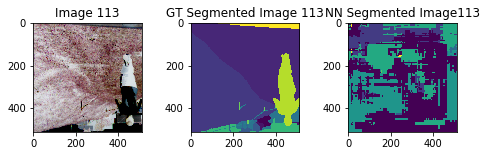

In [16]:
torch.cuda.empty_cache()
def colorize_mask_nn_output(mask):
    new_mask = Image.fromarray(mask.astype(np.uint8)).convert('P')
    new_mask.putpalette(palette)
                      
    return new_mask


untrained_net = Net().to(device)
untrained_net.eval()

sample_img, sample_target = train_data[113]

untrained_output = untrained_net.forward(sample_img[None].to(device))
if device != 'cpu':
    untrained_output = untrained_output.cpu()
untrained_nn_seg_img_113 = torch.argmax(untrained_output.cpu(), dim=1).numpy()[0]

fig = plt.figure(figsize=(8,2))
add_img_plot(fig, 113, transforms.ToPILImage()(img_113), 'Image ', [1,3,1])
add_img_plot(fig, 113, colorize_mask(seg_img_113), 'GT Segmented Image ', [1,3,2])
add_img_plot(fig, 113, colorize_mask_nn_output(untrained_nn_seg_img_113), 'NN Segmented Image', [1,3,3])

In [17]:
def train(train_loader, net, optimizer, loss_graph, device):
    for batch_idx, (data, target) in enumerate(train_loader):
        img, gt_seg_img = data.to(device), target.to(device)
        # This is a forward pass which also returns loss due to training mode    
        main_loss = net(img, gts=gt_seg_img)
        
        # Populate this list to graph the loss
        loss_graph.append(main_loss.item())
        
        # View the loss within the epoch
        print(main_loss.item())
        
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        main_loss.backward()
        optimizer.step()
        
    return main_loss

In [18]:
def get_optimizer(net):
    optimizer = torch.optim.SGD(net.parameters(),
                               lr=0.1,
                               weight_decay=1e-5,
                               momentum=0.5,
                               nesterov=False)
    return optimizer

Starting Training...
3.6419613361358643
3.851911783218384
3.4268746376037598
3.12375545501709
3.0180888175964355
3.407086133956909
2.8990976810455322
2.7744140625
3.0372257232666016
3.1457479000091553
2.9964382648468018
2.473646879196167
2.438170909881592
2.7497501373291016
3.192567825317383
2.2707743644714355
2.726962089538574
2.7176854610443115
2.7986133098602295
2.4464075565338135
2.1343324184417725
2.1774563789367676
2.651209831237793
2.1213879585266113
3.0563199520111084
2.557173013687134
1.9050688743591309
2.314255475997925
2.5817973613739014
2.783298969268799
2.563446521759033
1.8610115051269531
1.984090805053711
2.692978620529175
2.148716449737549
2.546618700027466
2.7275524139404297
2.1489109992980957
2.32609224319458
2.656485080718994
2.6206538677215576
2.3657758235931396
2.021536350250244
2.885531187057495
2.8563895225524902
2.106466770172119
2.1058127880096436
2.5048999786376953
2.1643123626708984
2.580137014389038
2.303978204727173
2.111581563949585
1.8692922592163086
2.08

1.7189867496490479
2.097867012023926
2.1764883995056152
1.792128324508667
Epoch: 1 Loss: 1.792128324508667
2.178506374359131
1.4085263013839722
1.6546390056610107
2.0406956672668457
1.363878607749939
1.7200785875320435
1.4674954414367676
1.0971269607543945
1.2650163173675537
2.181476354598999
1.3290361166000366
1.8042168617248535
1.4262367486953735
1.6018493175506592
1.630506157875061
2.1496965885162354
1.7121262550354004
2.0736405849456787
1.0143663883209229
1.3309212923049927
1.6131230592727661
1.688043236732483
2.3377137184143066
1.07628333568573
1.9159061908721924
1.684146761894226
1.4071969985961914
1.8949594497680664
1.205731987953186
1.2031084299087524
1.776038646697998
1.4112281799316406
1.6810754537582397
1.4448755979537964
1.4600615501403809
1.836206316947937
1.2117547988891602
1.1789331436157227
2.146648406982422
1.6367863416671753
1.4486300945281982
1.6846721172332764
2.3779659271240234
1.0726442337036133
1.1075403690338135
2.096179723739624
1.4540585279464722
2.15191006660

2.0400376319885254
0.916388750076294
0.9846664667129517
2.1816368103027344
1.2551403045654297
2.1332812309265137
1.528678059577942
2.130117654800415
1.396698236465454
Epoch: 3 Loss: 1.396698236465454
1.432199239730835
2.1150293350219727
1.3872902393341064
2.249891996383667
1.387021780014038
1.5140507221221924
0.8083454966545105
1.2200796604156494
1.3213897943496704
1.929382085800171
1.1487903594970703
2.0041043758392334
1.617915391921997
1.4857348203659058
1.2466702461242676
1.430438756942749
1.421301245689392
1.61619234085083
1.1964534521102905
1.5435715913772583
0.9413825273513794
1.510455846786499
1.126129150390625
1.717146396636963
1.839780569076538
1.0846425294876099
1.5092203617095947
1.496363639831543
1.6530933380126953
1.4836101531982422
0.9587661027908325
0.8235396146774292
1.0225598812103271
1.6027698516845703
0.9091899394989014
0.9710223078727722
0.8733507394790649
1.2593027353286743
3.341599941253662
1.1229453086853027
1.1330628395080566
1.551809310913086
0.8842183351516724

1.1328524351119995
1.9227792024612427
1.7485380172729492
1.5831692218780518
1.0128488540649414
1.4026665687561035
2.2659268379211426
1.6871612071990967
1.3150001764297485
2.5410146713256836
2.0882794857025146
0.9656163454055786
1.629390835762024
1.860274314880371
1.1778990030288696
Epoch: 5 Loss: 1.1778990030288696
1.8596582412719727
1.106291651725769
1.4129096269607544
1.8999271392822266
0.8909273147583008
1.4445135593414307
1.7084529399871826
1.4279074668884277
1.5801032781600952
0.9984172582626343
1.205694317817688
1.2343806028366089
1.0252362489700317
1.6154696941375732
0.9649916291236877
1.3844279050827026
1.5543835163116455
0.8144069314002991
1.378962516784668
1.5834097862243652
1.6645936965942383
1.1364216804504395
1.2569855451583862
1.0632842779159546
1.0718040466308594
1.1655948162078857
1.2946091890335083
1.78071928024292
1.770839810371399
1.3455238342285156
2.197267770767212
1.2027437686920166
1.6699978113174438
2.0571703910827637
1.1535313129425049
1.6313787698745728
1.0227

0.8690701127052307
0.7982098460197449
0.8988159894943237
1.2960892915725708
2.056647300720215
0.9333100318908691
1.571955919265747
0.860796332359314
1.7723791599273682
1.5021681785583496
1.8385229110717773
1.301039695739746
1.8069262504577637
1.5839320421218872
1.3206589221954346
1.0607459545135498
1.2914727926254272
1.0830726623535156
0.5717633366584778
0.9017728567123413
1.27677321434021
1.2766362428665161
Epoch: 7 Loss: 1.2766362428665161
1.0752432346343994
1.3272490501403809
0.9419974088668823
1.4294936656951904
1.9131124019622803
1.4861230850219727
1.2213058471679688
0.7257934212684631
1.5933489799499512
1.1998541355133057
1.1190266609191895
1.8350225687026978
1.0645415782928467
1.8749186992645264
1.4753397703170776
0.8208281397819519
1.9627606868743896
1.432629108428955
0.8749637007713318
1.2117005586624146
1.2829415798187256
2.196941375732422
1.5000126361846924
1.0669177770614624
1.2818368673324585
1.3428095579147339
1.3347269296646118
1.3378753662109375
1.2816107273101807
0.787

1.3501133918762207
1.4389257431030273
1.213117241859436
0.9096235632896423
1.6458253860473633
1.0353413820266724
1.5212434530258179
1.1145753860473633
1.7361488342285156
0.911612868309021
1.6347482204437256
0.8817938566207886
1.764206051826477
2.2799854278564453
0.7013985514640808
1.9626768827438354
1.1441781520843506
0.9492695331573486
1.4537887573242188
0.7402623891830444
1.2491782903671265
0.97569739818573
0.8773987293243408
1.154874563217163
1.3504465818405151
2.730375289916992
0.9361189007759094
1.257544994354248
Epoch: 9 Loss: 1.257544994354248
1.6970882415771484
1.0483894348144531
0.9793537855148315
1.7327677011489868
1.9315025806427002
1.1592344045639038
0.8505361676216125
1.0560353994369507
0.8053244352340698
0.7259976863861084
1.0756855010986328
1.0628859996795654
0.8759933114051819
0.8027908802032471
2.4130711555480957
0.8108866214752197
1.3810325860977173
1.1156920194625854
1.3266732692718506
1.2899061441421509
1.4165101051330566
0.788854718208313
1.2726892232894897
1.33097

1.487274408340454
1.052411437034607
1.5146331787109375
0.812781810760498
1.5824306011199951
1.593827724456787
0.9012705087661743
0.763211727142334
0.8762280344963074
1.5899477005004883
0.9435399174690247
1.2075045108795166
0.5560640096664429
1.344901204109192
1.449395775794983
1.1475571393966675
1.1846227645874023
1.5802810192108154
1.2730128765106201
0.5758998394012451
0.966588020324707
1.5356065034866333
0.6388429403305054
0.8929570317268372
1.1284500360488892
1.5363858938217163
0.9721001386642456
0.7036916017532349
1.793337345123291
1.3248655796051025
0.9444054365158081
1.2216136455535889
2.639946937561035
1.5447511672973633
Epoch: 11 Loss: 1.5447511672973633
1.1929420232772827
1.0367718935012817
0.6209805011749268
1.5328567028045654
1.0994923114776611
1.625997543334961
1.272096037864685
1.4292174577713013
1.3941905498504639
1.2106311321258545
1.0966804027557373
2.1021108627319336
1.6653519868850708
1.388092041015625
0.8405468463897705
1.1707758903503418
0.9584246873855591
0.6616762

0.9276257157325745
1.9026356935501099
0.6531838178634644
1.0269811153411865
1.239501953125
1.2523425817489624
0.888379693031311
1.1031241416931152
1.4864174127578735
1.7358767986297607
1.034752607345581
0.7516211271286011
1.139043927192688
1.325423240661621
0.7845994830131531
0.7311804294586182
1.1831815242767334
0.9208008646965027
1.0905687808990479
0.5629482865333557
2.2108142375946045
1.4024641513824463
0.7278650403022766
1.0120404958724976
1.1266411542892456
0.862502932548523
0.9896003007888794
0.7332398891448975
1.4020520448684692
2.446099281311035
1.336429238319397
1.4696383476257324
1.0750322341918945
1.0417537689208984
0.9949005246162415
0.7549723386764526
1.1006982326507568
0.7508337497711182
0.815648078918457
1.0547795295715332
Epoch: 13 Loss: 1.0547795295715332
1.209565281867981
1.134308099746704
1.0458873510360718
0.7509244680404663
1.3100029230117798
1.4543464183807373
1.7982231378555298
0.8040499687194824
0.7545350790023804
1.4047846794128418
1.127543330192566
1.131717205

0.6309263110160828
1.1542258262634277
1.255105972290039
1.337483286857605
0.787028431892395
1.2119266986846924
0.7725124359130859
0.7593613266944885
1.288374423980713
0.6607917547225952
1.600127935409546
1.121668815612793
0.8370516300201416
0.961695671081543
1.0642197132110596
0.6582823991775513
0.7701071500778198
1.3086674213409424
1.0048494338989258
1.0578806400299072
0.667310357093811
0.6408421993255615
1.4946577548980713
0.924639105796814
0.9246247410774231
1.8002161979675293
1.5893644094467163
1.0630276203155518
1.4610581398010254
1.3806782960891724
1.4270700216293335
1.186858892440796
0.841427206993103
0.7128099799156189
1.1286289691925049
0.9655163288116455
1.5593794584274292
1.0259538888931274
1.1771960258483887
0.6077151894569397
0.589666485786438
1.73508882522583
0.9086886644363403
0.7406219244003296
1.5370683670043945
1.5539510250091553
1.2525699138641357
1.3723211288452148
Epoch: 15 Loss: 1.3723211288452148
1.3100686073303223
1.1810539960861206
1.8257743120193481
0.93762934

0.8208122253417969
0.8692204356193542
2.2944984436035156
0.9192671179771423
0.7744958400726318
0.8219342827796936
0.9901160597801208
1.6942529678344727
1.0435729026794434
1.1538586616516113
1.286756992340088
0.7962955236434937
1.0943737030029297
0.8984874486923218
1.0054259300231934
1.1430896520614624
2.822181224822998
0.7765834927558899
0.8014702796936035
1.8283076286315918
1.3400585651397705
1.3926851749420166
1.2847743034362793
1.5282466411590576
0.8901684880256653
0.8803682923316956
1.0919238328933716
0.5497220754623413
0.6506321430206299
0.5667804479598999
1.0595465898513794
0.9653042554855347
0.9214627742767334
0.8000807762145996
0.6189484596252441
1.3247746229171753
1.375502586364746
1.0350035429000854
0.8608545064926147
0.8059253692626953
0.9006443023681641
1.2021812200546265
1.153169870376587
1.5015544891357422
0.9162105321884155
1.1536046266555786
1.0794421434402466
1.2392091751098633
1.3436810970306396
0.8076980113983154
1.839565634727478
1.0385781526565552
1.554479241371154

1.0510157346725464
0.5532926321029663
1.3075851202011108
0.9186578392982483
1.239716649055481
0.8998599648475647
1.694860577583313
1.336854100227356
1.1339874267578125
0.7458475232124329
1.9383544921875
0.9049780368804932
0.7109419107437134
2.1492366790771484
0.8865934610366821
2.039243221282959
0.6934503316879272
1.5838878154754639
1.0448520183563232
0.8927269577980042
1.2866849899291992
0.9149401187896729
0.9255249500274658
0.8925098776817322
1.4470149278640747
1.2873940467834473
1.1643446683883667
0.5924398899078369
1.074652075767517
1.6449096202850342
0.6738406419754028
1.1220839023590088
0.8483321666717529
0.5291250944137573
0.4704357981681824
0.8831163644790649
1.4325493574142456
0.7703003883361816
2.181877374649048
0.9850772023200989
0.7721607089042664
1.0090582370758057
1.32905912399292
1.6558929681777954
1.6533671617507935
1.6158051490783691
1.0230438709259033
1.5039411783218384
1.1138635873794556
0.8358443379402161
0.8852744102478027
0.7765035629272461
1.03947114944458
0.8060

1.003827691078186
0.8564149737358093
0.6453930139541626
0.8386985063552856
0.646385669708252
1.0182385444641113
1.0189075469970703
0.7685727477073669
0.8193614482879639
0.7017174959182739
0.8980259895324707
0.942939281463623
1.3945400714874268
2.0946145057678223
1.1915777921676636
1.441417932510376
2.040694236755371
1.007784128189087
1.1225401163101196
1.231034517288208
0.807800829410553
1.4768778085708618
0.7940126657485962
1.7171366214752197
1.5297406911849976
0.6610114574432373
0.8925387859344482
0.9487723112106323
1.145074486732483
0.9635802507400513
1.226048469543457
1.2167028188705444
0.8908950090408325
0.5859547257423401
1.3488692045211792
1.2482651472091675
0.8697763681411743
0.647506594657898
0.9754889607429504
1.6517422199249268
0.7031115293502808
1.8696194887161255
0.8523010611534119
0.8592502474784851
0.896063506603241
0.8056676387786865
0.6414908170700073
0.8903930187225342
1.2846806049346924
1.6905726194381714
0.9457671642303467
1.4355930089950562
1.799319863319397
1.9693

1.4053990840911865
0.39423906803131104
0.6666852831840515
1.3224364519119263
0.8582932949066162
1.3912822008132935
1.0488498210906982
1.3434734344482422
1.080247163772583
0.6052560806274414
1.4072577953338623
1.0314431190490723
1.064481258392334
0.8523813486099243
1.4837620258331299
1.4862526655197144
0.8471003174781799
0.8015297651290894
1.2574371099472046
0.6209483742713928
0.6225218176841736
0.9041396379470825
0.6600105166435242
0.5004048347473145
0.5892630219459534
1.3305875062942505
2.0578060150146484
1.132904291152954
1.0566723346710205
0.678203284740448
1.7994399070739746
0.7217590808868408
1.3707518577575684
0.594900369644165
0.7483389973640442
1.1044337749481201
1.0528455972671509
1.1250078678131104
0.9316002726554871
0.6159576773643494
1.0837435722351074
1.0871329307556152
0.8935710191726685
0.9914482831954956
1.026023030281067
1.0826733112335205
0.8493989706039429
1.3969833850860596
0.9575074911117554
1.50221848487854
0.9370232820510864
1.0442205667495728
1.0613746643066406


0.6582211256027222
1.2942413091659546
2.046175718307495
0.8648289442062378
0.9347808361053467
1.3932831287384033
1.4031600952148438
0.9697109460830688
1.083975911140442
1.037204384803772
0.874725341796875
1.3058500289916992
0.7435613870620728
1.3661201000213623
0.6109652519226074
0.8231381177902222
1.497075080871582
1.6103646755218506
0.8230454921722412
0.7844758629798889
0.9111073613166809
1.6757919788360596
0.7691147327423096
1.2960556745529175
0.5954004526138306
0.6868141889572144
1.170668363571167
0.8793985247612
0.5065726637840271
0.8381742238998413
1.1896967887878418
0.9319101572036743
0.7933849096298218
1.1405233144760132
1.2667834758758545
0.49097931385040283
0.6778656244277954
0.8984971642494202
0.6354997754096985
0.8961115479469299
0.5849936604499817
1.2373027801513672
1.010071039199829
0.9699652194976807
0.6216112375259399
0.552346408367157
1.134836196899414
0.8481643199920654
0.6865664124488831
0.4914954900741577
1.396769642829895
1.3713383674621582
0.6394731998443604
0.542

1.175793170928955
0.6807450652122498
0.673623263835907
1.13667631149292
0.47115737199783325
0.743686318397522
0.735159158706665
0.739554762840271
1.3172481060028076
2.0591788291931152
0.835353672504425
1.4655611515045166
1.8455660343170166
1.5491622686386108
0.6749007701873779
1.3733575344085693
0.7198716402053833
0.6273091435432434
0.5874227285385132
0.7130887508392334
0.8099037408828735
0.9388014078140259
0.6521939039230347
1.0632755756378174
0.9685752391815186
0.7053661346435547
0.4450065493583679
0.5559966564178467
0.5713517665863037
0.7741454839706421
3.0236103534698486
1.175362467765808
0.8294248580932617
1.6781587600708008
0.8171213269233704
2.151120662689209
1.0859953165054321
1.535184383392334
0.9497172832489014
1.0019134283065796
0.9385932683944702
0.7929935455322266
1.0326790809631348
0.9223923087120056
0.609149694442749
1.5374815464019775
0.6748836040496826
1.4438660144805908
1.015626311302185
1.4184883832931519
0.6537589430809021
1.416259527206421
1.094039797782898
0.96890

0.5705111622810364
1.1582317352294922
0.6244038343429565
0.38587242364883423
0.5710979700088501
1.080493450164795
0.43529564142227173
0.787212610244751
1.2199257612228394
3.0262999534606934
1.3456592559814453
1.415005087852478
0.8481850028038025
0.9085360765457153
0.9709979295730591
0.8251467943191528
0.7291222810745239
0.4585307836532593
1.00139582157135
0.8549515008926392
1.7249118089675903
1.1061789989471436
1.5005977153778076
1.5565121173858643
2.833242177963257
1.7210495471954346
1.0459295511245728
1.817916750907898
0.5221236944198608
1.4172388315200806
0.817725658416748
0.9946895837783813
0.9207687973976135
0.7500017881393433
0.5111244916915894
1.0072818994522095
0.6531270742416382
0.8053990006446838
0.7127928733825684
0.6342938542366028
0.7104864120483398
1.3835551738739014
0.7526249885559082
1.1983041763305664
1.348586082458496
0.435802698135376
0.4959075450897217
1.3208354711532593
1.126603126525879
0.9581121206283569
0.7577441930770874
0.8867084980010986
1.1763432025909424
1.

0.668383002281189
1.4829509258270264
0.8163009881973267
0.8449643850326538
1.2394568920135498
0.7572236657142639
0.80362468957901
1.347934365272522
0.7183611989021301
0.7962019443511963
0.6735193133354187
1.1107348203659058
0.5270336866378784
1.657926321029663
1.3831472396850586
1.5061914920806885
1.9096788167953491
2.8640341758728027
1.4338464736938477
1.9604358673095703
0.5807297229766846
1.0843135118484497
1.3419510126113892
1.1406229734420776
1.7737584114074707
1.3414888381958008
0.9995251893997192
1.0056647062301636
1.0113118886947632
1.9584829807281494
1.0056805610656738
0.7711719870567322
0.877984881401062
1.1400351524353027
0.6547397375106812
0.9249864220619202
0.7162379026412964
0.9847103953361511
0.8796501755714417
1.1546953916549683
1.771232008934021
1.6497340202331543
1.4142571687698364
0.49746572971343994
0.9319539070129395
0.3700857162475586
1.0374350547790527
0.756704568862915
1.0213161706924438
0.6942951679229736
0.9140128493309021
1.0165534019470215
0.7934412360191345


0.9196762442588806
1.0337722301483154
0.6330735683441162
1.221551775932312
0.5298394560813904
0.4935508668422699
0.8143621683120728
0.8274766206741333
0.6380712985992432
0.5345363616943359
0.5011205673217773
0.6458835005760193
0.7137230634689331
2.200136184692383
1.5417945384979248
0.669621467590332
0.866341233253479
1.1293658018112183
1.189438819885254
1.3123316764831543
0.7580035924911499
1.0245380401611328
0.5394919514656067
0.4727061092853546
2.1118624210357666
0.6682085990905762
0.8301001787185669
1.2661749124526978
1.037268042564392
0.9908414483070374
1.2064926624298096
1.3397400379180908
0.4615955054759979
0.5073738694190979
1.2415688037872314
1.887023687362671
1.3032342195510864
0.575727641582489
1.5370490550994873
2.2587103843688965
1.0608181953430176
0.47976064682006836
0.7594866156578064
1.2253806591033936
0.5231150388717651
1.1116873025894165
0.5772110223770142
1.2872428894042969
0.743598997592926
1.1339744329452515
0.42360958456993103
1.0764586925506592
1.0490666627883911


0.6919465065002441
2.0220861434936523
1.0865287780761719
0.736747145652771
0.7202932238578796
1.2435095310211182
1.1372607946395874
0.4036797285079956
0.8311021327972412
1.16367769241333
0.7479920387268066
0.6470465660095215
1.5858396291732788
1.0072407722473145
0.9262561798095703
0.7985767126083374
1.0949056148529053
0.6981768608093262
0.5580646395683289
0.45634791254997253
0.976157009601593
0.5869438648223877
0.5356877446174622
1.9100823402404785
0.5582281947135925
1.1020383834838867
0.7304344177246094
1.4361414909362793
1.2068347930908203
0.7683570384979248
0.5762974619865417
0.7166920900344849
1.767615556716919
1.0540134906768799
0.8425077795982361
1.3281244039535522
0.413551390171051
0.47374868392944336
0.8502050042152405
0.5490096807479858
0.764279305934906
0.862924337387085
0.6314999461174011
1.27251398563385
1.7031540870666504
1.5199556350708008
1.0542420148849487
1.4570789337158203
0.5831091403961182
0.4178380072116852
0.5358320474624634
0.7549638152122498
0.9718065857887268
0

1.073355793952942
1.0821123123168945
1.9362725019454956
0.8054338097572327
0.8219882249832153
1.863118290901184
1.2843987941741943
1.55889093875885
1.5087668895721436
0.6170754432678223
1.212456464767456
1.367264986038208
1.229910135269165
2.0222063064575195
0.8177823424339294
0.6360976696014404
1.405921459197998
0.9220659136772156
0.730385422706604
0.49698176980018616
1.261696457862854
0.9451145529747009
1.0200682878494263
0.3097724914550781
0.7637414336204529
0.8061184883117676
0.6729419827461243
0.6714503765106201
0.5809136033058167
1.2866864204406738
0.43351322412490845
0.6271233558654785
0.5813479423522949
1.1099011898040771
0.3994959592819214
0.5927376747131348
1.1124012470245361
0.7233284115791321
0.7846282124519348
0.607712984085083
0.7079927921295166
1.699206829071045
0.650783360004425
0.5132002830505371
2.265399932861328
0.8174805045127869
0.6772412061691284
0.6845442652702332
0.9007694721221924
1.0975313186645508
0.6802564859390259
0.5802845358848572
0.7092898488044739
0.746

0.6271582841873169
0.6400816440582275
0.7522405385971069
0.9026424288749695
0.9238776564598083
1.3415188789367676
0.6301965713500977
0.7121903896331787
0.8050246238708496
1.0744662284851074
0.7353267669677734
0.4704977869987488
1.0972647666931152
0.8791078925132751
0.5579656958580017
0.6824606657028198
0.7097262144088745
2.705040454864502
0.41468894481658936
0.4031788408756256
0.6556395292282104
1.5099971294403076
0.3837938904762268
2.229731559753418
1.7979252338409424
0.748013436794281
1.5444755554199219
0.9331914186477661
0.7328779697418213
0.5832687616348267
0.8718182444572449
1.4094657897949219
0.778075098991394
0.6686900854110718
1.0285253524780273
1.2700002193450928
0.7815157771110535
1.5311731100082397
0.9371719360351562
1.3024544715881348
1.7655818462371826
1.5998868942260742
0.691124439239502
1.6908032894134521
0.8993335962295532
0.5493544340133667
1.0375652313232422
1.2845609188079834
2.023824453353882
0.36014524102211
0.6029943227767944
0.7281915545463562
0.7844585180282593


0.9996676445007324
0.7275475263595581
0.6577054858207703
0.5143940448760986
0.4610041379928589
0.9350913763046265
1.0914945602416992
0.8873702883720398
1.074493646621704
1.0425459146499634
1.0488309860229492
0.670206606388092
0.8547189235687256
1.426668643951416
1.0079054832458496
1.3972561359405518
0.7659235000610352
1.3437132835388184
0.6324533224105835
0.6373355388641357
2.076247215270996
0.8380839824676514
1.759203553199768
1.5638039112091064
0.8051341772079468
0.7547754049301147
1.6210235357284546
1.5632984638214111
1.0134990215301514
1.3386294841766357
1.0779973268508911
0.8148030638694763
0.48790252208709717
1.2821509838104248
0.529177725315094
0.5367265939712524
0.9065866470336914
0.9334346055984497
0.8068941831588745
0.7932698726654053
0.9307655096054077
0.9488617777824402
0.5706031322479248
1.0860788822174072
1.059494137763977
0.5994282960891724
1.0560044050216675
1.9258825778961182
1.0166460275650024
1.0418527126312256
1.062410593032837
1.0329761505126953
0.7483162879943848


0.6163104772567749
1.2011903524398804
0.6696137189865112
2.472477674484253
1.4587347507476807
0.6587897539138794
0.702725350856781
0.5821415781974792
1.4055194854736328
0.8994449377059937
1.2161529064178467
1.211446762084961
0.7098388075828552
0.7483659386634827
1.452091097831726
0.9103705883026123
1.183772325515747
0.7733704447746277
0.8912867307662964
0.4565560519695282
0.92692631483078
0.8969089984893799
0.7722415924072266
0.7226216793060303
1.8023110628128052
0.5681047439575195
0.7870253920555115
0.7500364184379578
1.9616941213607788
0.7044362425804138
0.8497452139854431
1.1671448945999146
0.6733386516571045
0.5928518176078796
0.6565101742744446
2.4334020614624023
0.8843035697937012
0.7532154321670532
1.2970898151397705
0.9999902844429016
1.1338419914245605
1.0043896436691284
1.086052417755127
0.7741181254386902
0.7114444375038147
0.5036958456039429
2.980281114578247
0.6090731024742126
1.1411211490631104
1.083461046218872
1.2359670400619507
1.0697273015975952
1.1390875577926636
0.7

0.6008869409561157
1.5885697603225708
0.9961696863174438
1.3549970388412476
0.7619509696960449
0.8968489170074463
0.8717585802078247
0.8379079699516296
0.6342702507972717
0.7411643862724304
1.197176218032837
1.6467020511627197
0.9211916923522949
0.7203522324562073
0.47559934854507446
0.6257896423339844
0.9457014799118042
1.6259437799453735
0.4018824100494385
1.13857901096344
0.8798421621322632
0.5799157023429871
0.792813241481781
0.7912948131561279
0.8427554368972778
0.500274658203125
1.4032350778579712
0.6508296728134155
0.7253888249397278
0.9742957949638367
0.7586607933044434
1.0223174095153809
0.7431689500808716
1.5505669116973877
0.4121686816215515
0.5713040828704834
0.7077382802963257
0.6401544213294983
0.8101474046707153
0.7669126987457275
0.39342254400253296
0.7438008785247803
1.359191656112671
1.0051443576812744
0.8489075899124146
0.6604673862457275
0.45471420884132385
0.6042831540107727
1.0510139465332031
1.0352272987365723
0.9411505460739136
0.4356432557106018
0.5159213542938

0.6974467635154724
0.7450354099273682
0.3784363567829132
1.676374912261963
0.701141893863678
0.8027834892272949
0.9410041570663452
0.45419126749038696
1.2083945274353027
0.7138223052024841
0.894818902015686
1.7610571384429932
0.5901581645011902
0.5157579779624939
0.6936715245246887
0.970707356929779
0.7008049488067627
0.3231881558895111
0.9334731101989746
0.8285523653030396
1.558586597442627
0.9470964670181274
0.8180172443389893
0.7224293947219849
0.5835046768188477
0.8186616897583008
0.4892304539680481
1.1432721614837646
0.7421401143074036
0.7505422830581665
0.5580185055732727
0.5185497999191284
0.6370718479156494
1.1797372102737427
0.29719045758247375
0.693568229675293
1.2342156171798706
0.371540367603302
1.168164849281311
2.028576612472534
0.6826441287994385
0.8065871000289917
1.0570625066757202
0.7126777768135071
0.7697561979293823
0.7057474851608276
0.5277276039123535
0.6490775346755981
0.6348696351051331
1.1453204154968262
0.21586650609970093
0.8852189183235168
0.5181857943534851

0.5843452215194702
0.4601063132286072
0.5088363289833069
0.5207829475402832
1.0880534648895264
0.6335955858230591
0.7334133386611938
0.6157942414283752
0.8479211926460266
0.6992127299308777
0.6418535709381104
0.5590542554855347
0.44935303926467896
0.4484618008136749
1.0460178852081299
0.6535699367523193
0.25456690788269043
0.8432497978210449
1.1784991025924683
0.5135618448257446
0.5143382549285889
0.584583580493927
0.8342069387435913
0.5388815402984619
1.248238205909729
0.3659839332103729
0.47753646969795227
0.44270291924476624
0.984066903591156
0.766785740852356
1.070655107498169
0.9452475309371948
1.2452161312103271
1.2739593982696533
1.1362706422805786
1.3066964149475098
0.5993995070457458
0.9052764177322388
0.37608736753463745
0.42121464014053345
1.377699851989746
1.5783817768096924
0.8834662437438965
1.3426196575164795
0.47773295640945435
0.9256916046142578
0.6347004175186157
0.7623053789138794
0.7156451940536499
0.5369925498962402
1.0117864608764648
0.616410493850708
0.4605312645

0.7129307389259338
0.5049315690994263
0.8950698375701904
0.9677767753601074
1.5709911584854126
0.7554404735565186
1.0604244470596313
1.3613197803497314
1.0817526578903198
0.4477146863937378
1.0977509021759033
0.9725335240364075
1.985276699066162
1.0359241962432861
0.5919089913368225
0.45097866654396057
0.298567533493042
0.4129348397254944
0.9817044734954834
2.171698570251465
0.6553565263748169
0.34902939200401306
1.377244472503662
0.5169536471366882
0.7013909816741943
1.1595234870910645
0.5721858739852905
0.6187672019004822
0.5090389251708984
1.100368857383728
0.7541681528091431
0.5831267237663269
0.989609956741333
0.5860093235969543
0.9105567932128906
0.6726038455963135
1.0993245840072632
0.7877475619316101
0.8257381916046143
0.608595073223114
1.2038040161132812
0.5614134669303894
0.91185462474823
1.0047036409378052
1.1774098873138428
0.9285998344421387
0.8658075332641602
0.9581444263458252
2.903569221496582
0.955629825592041
0.8894974589347839
0.7599104046821594
0.4842751622200012
1.

0.7306484580039978
0.6728000640869141
1.2018680572509766
1.1193848848342896
0.5711183547973633
0.6378914713859558
1.6072078943252563
0.6063036918640137
1.116295337677002
1.141257643699646
1.5663912296295166
0.4301011860370636
0.7570391893386841
0.49011507630348206
0.3953498899936676
0.8779365420341492
0.4022817015647888
0.47430744767189026
0.9605783224105835
0.6216995716094971
0.7533590793609619
0.3680175542831421
0.6967768669128418
1.1884536743164062
0.34435877203941345
1.2208558320999146
0.9172424077987671
0.5508795976638794
1.595608115196228
0.9540067911148071
0.8966699838638306
0.551997184753418
2.2789833545684814
0.707886278629303
0.9370813369750977
0.7139749526977539
0.4610053300857544
1.0300753116607666
1.3659037351608276
0.4789247512817383
0.5132928490638733
0.5211971998214722
0.537355363368988
0.5445929169654846
0.8709474802017212
0.6263282895088196
0.49411869049072266
0.5044662952423096
0.6286296248435974
0.48877400159835815
0.6166743040084839
0.9351332783699036
0.49827101826

0.9351984262466431
Epoch: 54 Loss: 0.9351984262466431
0.5676491856575012
1.4095139503479004
0.6171151995658875
2.754439115524292
0.722180187702179
0.5100206136703491
0.8764057159423828
0.772052526473999
1.5915321111679077
0.8822503089904785
1.0023747682571411
0.9049335718154907
0.8011906147003174
0.7527866959571838
1.011122465133667
1.3292956352233887
1.1291786432266235
0.6088184714317322
1.0614807605743408
1.3440485000610352
0.6566411256790161
0.6660499572753906
0.6941416263580322
0.7256567478179932
0.8060062527656555
0.6272426843643188
1.1323872804641724
1.4498348236083984
0.47654786705970764
0.9155761003494263
0.8496057987213135
0.7289185523986816
1.0482146739959717
0.6020107269287109
0.687210202217102
0.7000771760940552
0.9869763851165771
1.2459166049957275
1.5279453992843628
0.679787278175354
0.8562964200973511
1.0146141052246094
0.6602926254272461
1.966570258140564
1.269383192062378
1.0113532543182373
0.7543652057647705
1.0197252035140991
1.0127671957015991
0.9654585123062134
0.7

1.6178840398788452
0.5344879627227783
0.5056672692298889
1.3246357440948486
1.0496306419372559
0.6152236461639404
0.6182683706283569
0.4241074025630951
1.1156888008117676
0.7885298728942871
0.7884451150894165
Epoch: 56 Loss: 0.7884451150894165
1.2698613405227661
0.4757133424282074
0.7006725072860718
1.065032958984375
0.5396519899368286
1.177494764328003
1.1515529155731201
0.2700965404510498
0.3465461730957031
0.4533674120903015
0.6821439862251282
1.1506047248840332
1.2324079275131226
0.8500999212265015
0.7999507188796997
1.5344390869140625
2.4564170837402344
0.41842058300971985
0.7830634117126465
0.5534631609916687
0.8509423732757568
0.9904122352600098
0.5201331377029419
0.8781904578208923
0.9916660189628601
1.0315195322036743
1.790012001991272
1.2083100080490112
0.9537520408630371
0.6452825665473938
0.5232916474342346
1.0602723360061646
0.5849687457084656
0.8114172220230103
0.7173284292221069
0.9128615856170654
0.5208036303520203
0.753813624382019
0.42130038142204285
0.806920766830444

0.7321087121963501
0.6870131492614746
0.7593491077423096
0.6055364608764648
0.7872729897499084
0.4937467575073242
0.8173056244850159
0.8924630880355835
0.6310285925865173
0.8182854652404785
0.6497111916542053
0.8841837644577026
0.8815358877182007
0.2736753523349762
0.31694334745407104
0.6380370259284973
0.6599686741828918
0.71258544921875
0.9529330134391785
0.7646579742431641
0.4952729642391205
1.0489100217819214
0.8843291401863098
Epoch: 58 Loss: 0.8843291401863098
0.3682824969291687
1.2212861776351929
0.4933903217315674
0.8156059980392456
1.7524852752685547
0.6040861010551453
0.794693112373352
0.7802730202674866
0.8275176286697388
0.6843245625495911
0.8213218450546265
0.9751222729682922
0.6204573512077332
1.0654006004333496
1.2468435764312744
1.3875185251235962
1.2785015106201172
0.5669073462486267
0.5609233975410461
0.45559898018836975
0.8335794806480408
0.8443628549575806
2.1708824634552
0.5517641305923462
1.0238478183746338
0.6673318147659302
0.4137706756591797
1.3489400148391724


1.0427476167678833
0.3548882305622101
1.1131776571273804
1.582685947418213
0.9219627976417542
0.5682967901229858
0.6646687388420105
0.942147970199585
0.8335412740707397
0.5712900161743164
0.9336673021316528
0.600152850151062
0.5313913822174072
0.6311554312705994
0.6042861342430115
0.7096495032310486
1.0996479988098145
1.029694676399231
0.8246744871139526
0.5692710876464844
0.6012964248657227
1.1571861505508423
0.9370095729827881
0.7204800248146057
0.6271929740905762
0.502609372138977
0.3989301919937134
1.0578351020812988
0.6131159067153931
0.7193505764007568
0.877973735332489
0.8717064261436462
0.9542407989501953
Epoch: 60 Loss: 0.9542407989501953
0.776109516620636
0.962483286857605
0.6040707230567932
1.4072550535202026
0.6572926044464111
0.6866568922996521
1.1449973583221436
1.3970849514007568
0.7891929745674133
0.4759025573730469
1.0775744915008545
0.820414662361145
0.39110708236694336
0.9593737721443176
0.788590133190155
1.7681922912597656
0.6553924083709717
0.5311760306358337
1.202

0.5331355333328247
0.6336030960083008
0.4839214086532593
0.9087872505187988
1.417256474494934
1.110597014427185
1.185113787651062
0.41334110498428345
0.7668878436088562
0.4414512515068054
0.36171677708625793
0.41711461544036865
0.5092982053756714
0.47718381881713867
0.40554460883140564
0.9572192430496216
0.7059499025344849
0.8558210134506226
1.5180065631866455
0.8496743440628052
0.6639755368232727
1.7685331106185913
0.47628504037857056
0.6563083529472351
1.2638638019561768
0.6614196300506592
0.6007700562477112
1.0525928735733032
0.5821437239646912
0.4915515184402466
1.3402012586593628
0.7536534070968628
0.4082026481628418
0.8227497339248657
0.854583740234375
0.7258365750312805
0.6087235808372498
0.7364333271980286
0.6560459733009338
0.5630040764808655
0.7066330909729004
1.1020272970199585
Epoch: 62 Loss: 1.1020272970199585
1.9192240238189697
0.5834200978279114
0.6177560687065125
0.5478624105453491
0.33965855836868286
0.7954410314559937
0.7389310598373413
1.7117376327514648
0.8247535824

0.9247714281082153
0.6280422210693359
0.7354795932769775
0.6435629725456238
0.7157814502716064
1.96676504611969
1.2241047620773315
1.460408091545105
0.5748145580291748
1.168790578842163
0.4804454445838928
1.028164029121399
1.1248726844787598
0.6747367978096008
1.0673866271972656
0.6573284864425659
0.5421402454376221
0.7610993385314941
0.6588467359542847
1.0519680976867676
0.5503487586975098
0.7822660207748413
0.4708443284034729
0.9405803680419922
0.8113648891448975
0.30753132700920105
0.7320391535758972
0.8586374521255493
0.5238597393035889
0.6408701539039612
0.9741581678390503
1.7601580619812012
0.6052839756011963
0.5320287942886353
0.7683172225952148
1.2339370250701904
0.3057916760444641
0.8732901215553284
0.6242120265960693
0.42393621802330017
0.8023945689201355
0.6453403234481812
0.539988100528717
1.4373703002929688
0.5906592607498169
0.6642793416976929
0.5895490050315857
1.2831484079360962
2.1411585807800293
0.9483118653297424
0.8878780007362366
0.6135796904563904
Epoch: 64 Loss: 

0.7058683633804321
0.4895784258842468
1.4689040184020996
0.6435936093330383
0.4901857376098633
0.6795855760574341
0.473970502614975
1.0457903146743774
0.40652817487716675
0.5742298364639282
1.2174811363220215
0.9217485785484314
1.2501707077026367
0.5780880451202393
0.45330432057380676
0.5261764526367188
0.47454947233200073
1.2982990741729736
0.7319067120552063
0.6393923163414001
0.35298582911491394
0.823794960975647
0.7381035685539246
0.7075051665306091
0.6638603806495667
0.8911310434341431
0.41633301973342896
0.5377442240715027
0.7948359847068787
0.596373975276947
0.5747565031051636
1.3061715364456177
0.7838473916053772
0.8929579257965088
0.7576382756233215
0.7499524354934692
0.8369897603988647
0.5722861289978027
1.4457261562347412
0.9589897394180298
1.024623155593872
0.6776717305183411
0.4540548622608185
0.8651295304298401
0.6290261149406433
0.4590969383716583
0.4264374375343323
0.689792811870575
1.1918312311172485
0.5031938552856445
0.7593751549720764
1.0015060901641846
1.0514518022

0.8569775819778442
1.0386576652526855
0.5250289440155029
1.5650975704193115
0.6979499459266663
0.848078727722168
0.534334659576416
0.9819458723068237
0.5260375738143921
0.3347615897655487
0.914736807346344
0.601077675819397
0.4783371388912201
1.586034893989563
0.6976484060287476
0.8573999404907227
0.7017139196395874
0.7387828230857849
0.43581444025039673
0.39213645458221436
0.9952170848846436
0.29591652750968933
0.8007077574729919
1.4724090099334717
0.758375883102417
0.6950027346611023
1.6301440000534058
1.562973976135254
1.2727738618850708
0.4227985739707947
0.5800802111625671
1.0781015157699585
0.6956495046615601
0.5108177661895752
1.1714494228363037
0.36109092831611633
1.2609871625900269
0.6389510035514832
1.4558542966842651
0.9914475679397583
0.3240355849266052
1.1585369110107422
0.44092854857444763
0.5745514035224915
0.6241220235824585
0.38849005103111267
0.3687945008277893
1.1673824787139893
0.7768255472183228
0.8189032077789307
0.6588419675827026
0.8150019645690918
0.38824838399

0.572252631187439
1.2206897735595703
0.5101686716079712
2.1974542140960693
0.5341522097587585
1.4094538688659668
0.5505465865135193
0.9649324417114258
1.1072417497634888
0.5436704158782959
0.6373227834701538
0.36283496022224426
1.0357537269592285
0.8503051996231079
0.8544201254844666
0.8997154235839844
0.46692171692848206
0.6697502136230469
0.8061169385910034
0.43730974197387695
0.4487000107765198
0.7705293893814087
0.6421769857406616
0.7601916790008545
0.6272417902946472
1.8548762798309326
0.681291401386261
0.5434145927429199
0.716521143913269
1.0543361902236938
0.8613433837890625
0.5906529426574707
0.4869942367076874
0.5165162682533264
1.1745808124542236
0.812925398349762
0.6868928670883179
1.0038199424743652
1.1519464254379272
0.6347270011901855
0.605463445186615
0.5800043344497681
1.0595074892044067
0.6879838705062866
0.6601006388664246
1.0139144659042358
0.7092766761779785
1.6633466482162476
0.9078145027160645
0.6727174520492554
0.7163631916046143
0.7365559935569763
0.761411309242

0.5392319560050964
1.1022067070007324
0.2551722824573517
1.3136043548583984
0.8795109987258911
0.707045316696167
0.3938434422016144
0.6771553754806519
0.5186434984207153
0.8007717132568359
0.4787251949310303
0.5349491238594055
1.1602941751480103
0.39046433568000793
0.5982091426849365
1.1585818529129028
0.6584606766700745
0.7573190927505493
0.5600242614746094
1.3753002882003784
0.8404794931411743
1.3101608753204346
0.5749410390853882
0.6740258932113647
0.3078705966472626
0.5958830118179321
0.7716497182846069
0.8741928935050964
0.769259512424469
0.2072119265794754
2.023653507232666
1.1332130432128906
0.7504078149795532
0.5425095558166504
0.4448659420013428
0.5797013640403748
0.2771633565425873
0.5392556190490723
1.6198556423187256
1.8957768678665161
0.4991263151168823
0.974414587020874
1.5947380065917969
0.6166083812713623
1.1549479961395264
0.7218776345252991
1.9173495769500732
0.8496628999710083
1.2123485803604126
0.7816811203956604
0.6177029013633728
0.3879614770412445
0.8625555038452

0.8065691590309143
1.131662368774414
1.504701852798462
1.8983116149902344
0.6645525693893433
0.43156149983406067
0.44043487310409546
0.6991001963615417
0.7310358881950378
0.48343560099601746
1.3916025161743164
0.5557115077972412
1.324548602104187
0.5979434251785278
1.1775989532470703
1.4392668008804321
0.8017703890800476
0.7000917792320251
0.5788801908493042
0.8455502390861511
1.036106824874878
0.6877952218055725
0.9508751034736633
0.7947826981544495
0.4069528877735138
0.6991031169891357
0.6596472263336182
1.260369062423706
0.8432779908180237
0.32811278104782104
0.49870049953460693
1.059489130973816
1.2778489589691162
0.9528491497039795
0.46476179361343384
0.46679168939590454
0.8010741472244263
0.9058557748794556
1.1791441440582275
0.5472404956817627
0.940833568572998
1.3337301015853882
0.416138231754303
0.805121898651123
0.7378038763999939
0.49836060404777527
0.3876854479312897
0.726038932800293
0.5132697224617004
0.7765696048736572
0.8322774171829224
0.7452343702316284
1.027240633964

0.7463801503181458
0.8724571466445923
0.4249652028083801
1.1060254573822021
1.2903083562850952
0.5227799415588379
0.5076755285263062
1.934890866279602
0.27754589915275574
0.5843079686164856
0.7853971719741821
0.8299304246902466
0.3550436794757843
0.492626428604126
0.9258893132209778
0.9359599947929382
0.4302877187728882
0.7716392278671265
1.4631110429763794
0.3830638527870178
0.8958906531333923
0.45540523529052734
0.47097086906433105
0.8949720859527588
1.1984243392944336
0.582655668258667
0.6299934387207031
0.6208100914955139
0.5892356038093567
0.7214267253875732
0.5786117315292358
1.065657377243042
0.5754114389419556
0.6284602880477905
0.8600188493728638
0.46575644612312317
0.3702663481235504
0.6492571830749512
0.5118554830551147
0.4713391065597534
0.6677075028419495
0.6783660054206848
0.6743683815002441
1.1441839933395386
1.006070613861084
0.8752420544624329
0.6302129626274109
0.49771416187286377
0.7486620545387268
0.9856182932853699
0.5345690846443176
0.7446951866149902
0.8140996098

0.8297280073165894
0.8585174679756165
0.5659199357032776
0.6065635681152344
1.0155138969421387
1.0663237571716309
0.6977210640907288
0.8463945984840393
0.9421013593673706
0.7512728571891785
1.124274492263794
0.4243779480457306
0.5979297757148743
0.8974490165710449
0.5699468851089478
1.7798889875411987
1.2025022506713867
0.7147853374481201
0.4428631663322449
0.7141266465187073
1.0730005502700806
1.1422322988510132
0.3063119053840637
0.4208564758300781
0.850763201713562
0.7913111448287964
0.48964568972587585
0.5272188186645508
0.6960175037384033
0.9110531806945801
0.983132541179657
0.5260931849479675
1.0015389919281006
0.6407709121704102
0.6051964163780212
0.5210093855857849
0.5117633938789368
0.47753530740737915
0.4202902019023895
0.4267757833003998
0.8279987573623657
0.3576752245426178
0.20608019828796387
0.5081570148468018
0.7969677448272705
0.8593636155128479
1.68831205368042
0.432873398065567
0.8073602914810181
0.8352033495903015
0.6404734253883362
1.2924017906188965
0.5681454539299

0.6363947987556458
1.0447660684585571
0.3435118496417999
0.3133738338947296
1.394197702407837
0.40583693981170654
0.30074575543403625
1.5946060419082642
2.0717904567718506
0.9457584023475647
0.9894290566444397
0.807905912399292
0.5138271450996399
0.8514523506164551
0.4959094226360321
0.5957619547843933
0.5570229887962341
0.9273055195808411
0.4881218671798706
0.7810857892036438
1.5078608989715576
1.9800336360931396
1.439933180809021
0.7394554615020752
0.9652906656265259
0.5397233366966248
0.9411223530769348
0.9715877175331116
0.6553452610969543
0.8929029107093811
0.793209433555603
0.8133854866027832
0.6450098752975464
0.4972136616706848
0.49642395973205566
0.9134494066238403
0.7413821220397949
0.8760793209075928
0.39642274379730225
0.4499927759170532
0.8910230398178101
0.4427860677242279
0.546471893787384
0.9523323774337769
0.6481545567512512
1.0486416816711426
0.6288211345672607
0.5365936160087585
1.0262250900268555
1.775197982788086
0.5721253156661987
1.1197391748428345
0.427138984203

0.5454466342926025
0.5409246683120728
0.9118742346763611
0.7458045482635498
1.1781271696090698
1.2303515672683716
0.6634701490402222
0.8216919302940369
0.8208006024360657
0.954258382320404
0.6160635352134705
0.6042495369911194
0.5855748057365417
0.4337199926376343
0.6713677644729614
0.29154202342033386
1.1158775091171265
0.36239272356033325
1.422796607017517
0.6902313828468323
0.6460291147232056
0.44322603940963745
0.4858362376689911
0.632806122303009
1.3666349649429321
0.3771403133869171
1.3684459924697876
0.6143586039543152
0.8221976161003113
0.9044685959815979
0.4169468879699707
0.8177969455718994
0.5910792350769043
1.0436934232711792
0.5012932419776917
0.8774679899215698
1.0271720886230469
0.5036211609840393
0.5553392171859741
0.5558053851127625
1.1521323919296265
0.6452280282974243
1.3547780513763428
1.001673936843872
0.5732605457305908
0.3087314963340759
0.7279869318008423
0.5163156986236572
1.0733153820037842
1.4573924541473389
0.9797641038894653
0.6879775524139404
2.66076350212

1.0131869316101074
0.6223449110984802
1.5311870574951172
0.4732843041419983
0.976249635219574
1.4989222288131714
0.8808099031448364
0.9672901630401611
0.7832912802696228
0.740853488445282
0.6839569807052612
0.8167887330055237
0.8991309404373169
0.3131420612335205
1.0791443586349487
0.31727278232574463
0.5879094004631042
0.6661818027496338
0.7072814106941223
1.3621870279312134
0.6475974321365356
0.4607622027397156
0.40401196479797363
0.9656672477722168
0.9962872266769409
1.2264634370803833
0.47599396109580994
1.514894723892212
0.6261159181594849
1.80015230178833
0.35301363468170166
0.30820077657699585
1.4005749225616455
0.6822210550308228
1.2080620527267456
2.4462392330169678
0.3181546628475189
0.9411084651947021
1.67195463180542
1.0806121826171875
0.7908225655555725
0.8706971406936646
0.9271342158317566
0.632145881652832
0.49837547540664673
1.2236065864562988
0.4542508125305176
0.7051717042922974
0.7486422061920166
0.35849907994270325
0.4540415406227112
0.6620282530784607
0.32989302277

0.6545720100402832
0.8973774313926697
0.5109178423881531
0.522727370262146
0.4246920645236969
0.3451772928237915
0.5792760848999023
1.0032435655593872
0.45276308059692383
0.7659844756126404
0.9762228727340698
0.6883191466331482
1.1492503881454468
0.3115081787109375
0.9760531187057495
0.6817393898963928
0.33348941802978516
0.6470335125923157
1.3656961917877197
0.3652648627758026
0.20793405175209045
0.7288710474967957
1.1897621154785156
0.41031721234321594
1.0379055738449097
0.4867163896560669
0.5220629572868347
0.7511576414108276
0.6766818761825562
0.5052553415298462
0.382897287607193
0.8816812038421631
0.5775694847106934
0.5510821342468262
0.7696827054023743
1.3543188571929932
1.1773700714111328
0.9075886011123657
0.639087438583374
0.9288640022277832
0.412578821182251
0.5461263060569763
0.555552065372467
0.43970999121665955
1.5555497407913208
1.2764437198638916
0.38094693422317505
0.5652408599853516
0.4401406943798065
1.902801752090454
1.6363617181777954
0.4145764112472534
1.0502161979

1.3146032094955444
0.5293543338775635
0.4748139977455139
0.4479227662086487
1.1526885032653809
1.3147664070129395
0.7047387957572937
0.8702553510665894
1.1363470554351807
0.4525928497314453
0.39451247453689575
1.0027756690979004
0.6921377182006836
0.4365624189376831
0.9895330667495728
0.42939499020576477
2.052443504333496
1.0939922332763672
0.7159978151321411
0.6412221789360046
0.5715035796165466
0.7624092698097229
0.8033429384231567
0.9841773509979248
0.5075968503952026
1.891121506690979
0.5765149593353271
0.7937048077583313
0.5757200717926025
0.46206504106521606
1.3808708190917969
0.6551374197006226
0.4692358374595642
0.7383816838264465
1.3860623836517334
0.6597471237182617
0.6483242511749268
0.2709302604198456
0.6686537265777588
0.4749668836593628
0.6150175929069519
0.36610743403434753
0.4987221956253052
0.3654555380344391
0.4743460714817047
0.8060569763183594
0.2938510775566101
1.1821234226226807
0.5495949983596802
1.138127088546753
0.924016535282135
0.3877517580986023
0.6939381957

0.25139757990837097
0.6631132364273071
0.7727698087692261
0.8128626942634583
0.7296536564826965
0.38873082399368286
0.6224271059036255
0.5683450102806091
0.7605537176132202
0.3967932462692261
0.9320242404937744
0.48635074496269226
0.7448834180831909
0.4239245653152466
1.2485148906707764
0.4255094826221466
1.0558444261550903
0.4821558892726898
0.5663633346557617
0.5895408987998962
1.0480380058288574
0.33246099948883057
0.6310966610908508
0.49693357944488525
0.7593166828155518
0.2453588992357254
0.31630733609199524
0.2882954478263855
1.2548913955688477
0.9315172433853149
0.8383855819702148
0.39905524253845215
0.4141976237297058
1.1223320960998535
0.5387176275253296
0.33884868025779724
0.5187935829162598
0.564315140247345
0.8314646482467651
0.36156347393989563
0.3987537622451782
0.9493306875228882
0.36329251527786255
0.5365740656852722
0.849982500076294
0.259426474571228
1.4918317794799805
0.7459838390350342
0.727388858795166
0.9119009971618652
1.7097748517990112
0.622715175151825
1.07380

0.6668769717216492
1.016765832901001
0.3555813431739807
0.5147020816802979
0.8787531852722168
0.2552109360694885
0.5606400370597839
0.9224889278411865
1.1575639247894287
1.507691502571106
0.6794303059577942
0.6132290363311768
0.3661695718765259
0.7429524660110474
0.6690781116485596
0.9318636655807495
0.5673308372497559
1.274881362915039
1.0308940410614014
1.0310852527618408
0.3554845154285431
1.027755618095398
0.7877610921859741
0.5654945373535156
0.583361804485321
0.6776927709579468
0.746874213218689
0.9021875858306885
0.7054047584533691
0.6133270263671875
0.6043688058853149
0.9430489540100098
0.41741669178009033
2.7295548915863037
0.4124395549297333
0.8282186985015869
0.43256229162216187
0.4961869716644287
0.25952544808387756
1.2906074523925781
0.5894584655761719
0.6540943384170532
0.5696029663085938
0.4474487900733948
0.7028552293777466
2.2072949409484863
0.46093660593032837
0.7575567364692688
1.506514072418213
0.673915684223175
0.7136898636817932
0.5597970485687256
0.38708677887916

0.47674423456192017
0.5644540190696716
0.7321197986602783
0.7024955153465271
0.8094985485076904
1.1348401308059692
0.9442282915115356
0.4100499451160431
1.5687692165374756
0.4870711863040924
1.0075064897537231
1.0335137844085693
0.6822201013565063
0.39246657490730286
0.4855836033821106
0.4329136908054352
0.5971962213516235
0.5455189943313599
1.4409815073013306
0.5747443437576294
0.7038185596466064
0.24183641374111176
0.5218952894210815
2.4754908084869385
0.24398291110992432
1.1349213123321533
1.1998077630996704
0.5671024918556213
0.3387233316898346
0.5284360647201538
0.5306712985038757
0.8327844142913818
0.34558433294296265
0.6721522808074951
0.6463927626609802
0.4742889702320099
0.6555204391479492
0.6858546137809753
0.3104347586631775
0.9691438674926758
1.1781699657440186
0.7857584953308105
0.6943047642707825
0.6386165022850037
1.0223994255065918
1.1020257472991943
0.6489946246147156
0.5397043824195862
0.4695282578468323
0.6946039199829102
1.0149173736572266
0.42860502004623413
0.8654

0.7317212820053101
0.6702553033828735
0.6156972646713257
0.6257140040397644
0.4057736396789551
0.3421819806098938
1.1861069202423096
0.557641863822937
0.8271797299385071
0.7336200475692749
0.798050582408905
Epoch: 95 Loss: 0.798050582408905
0.4187575876712799
0.6405160427093506
0.7386951446533203
1.1834875345230103
0.5370290279388428
0.5639798641204834
0.5769843459129333
0.38639000058174133
1.2043195962905884
0.3287830352783203
1.4834866523742676
0.21768565475940704
0.3044432997703552
0.4933566153049469
0.5153918862342834
1.0472195148468018
0.5483806133270264
0.6594938039779663
0.3247874975204468
0.3710746169090271
0.6156243085861206
0.5852175951004028
0.48750343918800354
0.23572894930839539
0.5673099756240845
0.4522166848182678
0.3648703098297119
0.3758860230445862
0.5869166851043701
0.6319856643676758
0.2939419746398926
0.38025546073913574
1.5154616832733154
0.43502697348594666
0.5765312314033508
0.5346952080726624
0.31875404715538025
1.7881304025650024
0.48277896642684937
0.84780156

1.1545542478561401
0.42570367455482483
0.7886736392974854
1.2649295330047607
0.7060925960540771
0.9036053419113159
0.476687490940094
0.5912720561027527
0.7214358448982239
0.4899858832359314
0.6141388416290283
1.1930128335952759
0.7892388105392456
0.32829493284225464
0.5439251661300659
0.9348829388618469
0.6310024261474609
0.4372338354587555
0.7809252738952637
1.1683382987976074
0.55066978931427
0.4480716586112976
0.3773837387561798
Epoch: 97 Loss: 0.3773837387561798
0.31718558073043823
1.4149720668792725
0.8468418121337891
0.48648566007614136
0.4903784692287445
0.5916486382484436
0.6945517659187317
0.8868246674537659
0.9735707640647888
0.2812533378601074
1.2877527475357056
0.6097427606582642
0.4374309778213501
1.5624057054519653
0.8330324292182922
0.5002286434173584
0.9336410164833069
0.6679211258888245
0.9165117740631104
0.4038904011249542
1.0290433168411255
0.6151604056358337
1.208449363708496
0.5289916396141052
0.4893668591976166
0.40561604499816895
0.9268614053726196
0.716551005840

0.5636470317840576
0.4966646134853363
0.8812472224235535
2.14036226272583
0.9162323474884033
0.6210123896598816
0.5197620987892151
0.7645368576049805
0.46646082401275635
0.4894530177116394
0.5647744536399841
1.6937912702560425
1.1222611665725708
0.5685184001922607
0.5227541923522949
1.5261585712432861
1.4482097625732422
0.7757361531257629
0.8373125791549683
1.3238089084625244
0.6622307896614075
0.8717885613441467
0.7149044275283813
0.48040279746055603
0.3102719187736511
0.37764114141464233
0.7237476706504822
0.4126337468624115
0.5314604640007019
1.0336387157440186
0.3560931086540222
0.9985211491584778
0.435344398021698
0.640532374382019
0.6856391429901123
Epoch: 99 Loss: 0.6856391429901123
0.6095671057701111
0.5371907353401184
0.7343329191207886
1.110010027885437
0.568356990814209
0.478057324886322
0.5155754685401917
0.6640357971191406
0.28269872069358826
0.7674528956413269
0.17988428473472595
0.6432876586914062
0.3799050748348236
1.0995540618896484
0.8634365200996399
0.496416419744491

0.9605761766433716
0.4252452552318573
0.4239393174648285
0.3713330924510956
0.8739933967590332
0.5375258326530457
0.629560649394989
0.4030945897102356
1.1171700954437256
0.43027424812316895
1.2361693382263184
0.29500874876976013
0.6948153376579285
0.3146699070930481
0.6772682070732117
0.45702821016311646
0.8936513662338257
1.7559053897857666
0.9144212007522583
0.5881096124649048
1.0005838871002197
0.6330288648605347
0.5450693368911743
0.6965962052345276
0.709138810634613
1.141148567199707
1.3545914888381958
0.6197105050086975
0.6459429264068604
0.437478244304657
0.7888169288635254
0.45190584659576416
0.41028299927711487
1.0738706588745117
0.6311330795288086
0.6109704971313477
0.45042872428894043
0.9542471170425415
0.5587986707687378
0.8307406306266785
1.3334726095199585
0.8013765215873718
0.4999629855155945
0.4114187955856323
0.5527994632720947
0.7104246020317078
0.2480287253856659
Epoch: 101 Loss: 0.2480287253856659
0.4603557884693146
2.1770143508911133
0.5748323798179626
0.3531979024

0.4064110517501831
0.7072510719299316
0.5703796148300171
0.28408414125442505
0.6152325868606567
0.7006816864013672
0.8464332818984985
1.5108795166015625
0.5089386701583862
0.2535460591316223
0.8030461072921753
0.6856178045272827
0.40570738911628723
0.9114617705345154
0.6211232542991638
0.8839790225028992
0.5109487771987915
0.9204461574554443
0.45570260286331177
0.5617032647132874
0.2677067816257477
0.6607638597488403
1.687549114227295
0.885033130645752
1.0134567022323608
0.4697501063346863
0.9426072835922241
0.41572409868240356
0.7587234377861023
0.7825802564620972
1.1580849885940552
0.2108810842037201
0.5617468953132629
0.9774224758148193
1.0554633140563965
1.404875636100769
0.5946904420852661
1.0449483394622803
0.7723798155784607
1.4183170795440674
0.730743408203125
0.8211587071418762
0.47210749983787537
0.5786468982696533
0.3228045105934143
1.6414834260940552
1.0589091777801514
0.9706712961196899
0.6259434223175049
0.4850807785987854
1.0093109607696533
0.6322082281112671
0.755179524

0.9710383415222168
0.3502092659473419
0.18935897946357727
0.9397156238555908
0.4623928368091583
0.5157812833786011
1.4559218883514404
0.7358837127685547
0.575161337852478
0.6768738627433777
0.8256914615631104
0.318167120218277
0.5847499966621399
0.6966820359230042
0.336467444896698
0.3757776618003845
0.9324855804443359
0.9488231539726257
0.48350706696510315
0.15220417082309723
0.6152971386909485
0.9383816719055176
0.4434182941913605
0.4751240909099579
0.5956466794013977
0.589236319065094
0.3838476538658142
0.8713102340698242
0.769196093082428
1.416411280632019
1.464253306388855
0.45877736806869507
0.3369908630847931
0.8743810653686523
0.6659008264541626
0.5085946321487427
0.8788695335388184
0.47263017296791077
0.45113393664360046
0.3450361490249634
1.5084742307662964
0.7960727214813232
1.1927876472473145
0.6395476460456848
0.545630931854248
0.9487496018409729
0.5070270895957947
0.5535185933113098
0.2891995310783386
0.5462754964828491
0.4424992799758911
0.8548694849014282
0.629718363285

0.8867158889770508
0.6296875476837158
0.3564552664756775
1.474236011505127
0.5237353444099426
1.0954111814498901
0.4670868515968323
0.70340895652771
0.4243307411670685
1.0701100826263428
1.3927881717681885
0.728570282459259
0.9133176803588867
0.8785582780838013
1.166526198387146
0.4911201000213623
1.039372205734253
0.8811895847320557
1.259121060371399
0.7745981216430664
0.5868399143218994
1.1481866836547852
0.9850215911865234
1.4609367847442627
0.5493372082710266
0.46573907136917114
1.1590704917907715
0.45696544647216797
0.5179784893989563
0.39149367809295654
0.8658632040023804
0.627553403377533
0.7425185441970825
1.0088484287261963
0.31490498781204224
0.8837920427322388
0.352804034948349
0.8358989357948303
1.0761984586715698
0.44358938932418823
1.0465916395187378
0.2825290560722351
1.3549195528030396
0.3817650079727173
1.5876572132110596
0.6451209783554077
1.033693790435791
0.6434119343757629
0.869681179523468
0.5120933055877686
0.4030960202217102
0.8918496370315552
0.7759333848953247

0.31394723057746887
0.6888750791549683
0.5464233160018921
0.5841099619865417
0.6214132308959961
0.35514992475509644
1.152992606163025
0.6668837070465088
0.4547120928764343
0.28278934955596924
0.5992617607116699
0.5204533338546753
0.5040470957756042
0.7402591109275818
0.5261135101318359
0.35643401741981506
0.6528097987174988
0.799136757850647
0.7615048885345459
0.6500782370567322
0.8696314692497253
0.6052189469337463
0.6173090934753418
0.6176487803459167
0.6315427422523499
0.7416245937347412
0.8441830277442932
0.4353433847427368
0.5896923542022705
0.23710806667804718
0.968070924282074
0.41411685943603516
0.424153208732605
1.024877905845642
0.47577977180480957
0.5334804654121399
0.4503714144229889
2.0337092876434326
0.759456992149353
0.7961230278015137
0.4312705993652344
0.3742046356201172
0.5214246511459351
0.570315420627594
0.6040076613426208
0.5371756553649902
0.4764448404312134
1.6050270795822144
0.4520564079284668
0.7992610335350037
0.34887585043907166
0.3867543339729309
0.867088675

0.3445095717906952
0.862829864025116
0.2179345041513443
0.45159462094306946
1.0965783596038818
0.39275413751602173
0.7390568256378174
1.5456039905548096
1.531969428062439
0.4227052628993988
0.5448927283287048
0.7726147174835205
1.3665599822998047
0.7889008522033691
0.7095152735710144
1.9737882614135742
0.5953844785690308
0.3117549419403076
0.6318451762199402
0.7282522916793823
0.9493957757949829
0.45663982629776
0.4797568917274475
0.5073562860488892
0.7814007997512817
0.5291897654533386
0.5597033500671387
0.5110858678817749
0.5863056182861328
0.5796862840652466
0.5493311285972595
0.32838016748428345
0.6751965880393982
1.146280288696289
0.6009052991867065
1.3509119749069214
0.5881171226501465
0.8898796439170837
3.152202844619751
0.541133463382721
0.5201316475868225
0.5044761300086975
0.3373246490955353
0.4071573317050934
0.8700544834136963
0.58207768201828
0.39635705947875977
1.1726417541503906
0.18316815793514252
0.6152632236480713
0.6528311967849731
0.4282553195953369
0.57508236169815

0.45300954580307007
0.7037597894668579
0.6725192070007324
0.33479124307632446
0.8786275386810303
0.5384213924407959
0.7169941663742065
0.6103562116622925
1.0354392528533936
0.39349958300590515
0.3623431921005249
0.6682819724082947
0.6371490359306335
0.24635431170463562
0.5193526744842529
0.36848893761634827
0.3952874541282654
0.4171551764011383
0.7405809760093689
0.36887726187705994
1.6910910606384277
0.5397325754165649
1.090296983718872
0.6918056607246399
0.4616081714630127
0.5667337775230408
0.5265204906463623
0.747702956199646
0.5929039120674133
0.7458885312080383
0.49201908707618713
0.4684271812438965
0.3033864200115204
0.8348499536514282
0.393892765045166
0.3087872266769409
0.5564460754394531
0.26946860551834106
0.4162747263908386
0.4149988293647766
0.6599612236022949
0.616601824760437
0.26960572600364685
0.4228646755218506
0.5352446436882019
0.4691724181175232
0.41117382049560547
0.45279625058174133
0.6923056244850159
0.6391546130180359
0.17183339595794678
0.427316278219223
0.451

0.30684199929237366
0.4974873661994934
0.5306593179702759
0.6728954911231995
0.45473989844322205
0.21744507551193237
0.6353178024291992
0.8211829662322998
0.802905797958374
0.5959420204162598
0.36707472801208496
0.26505833864212036
0.434439092874527
0.5734753012657166
0.3920574188232422
0.6460816264152527
0.4960046410560608
1.7426257133483887
0.8549696207046509
0.4201577305793762
0.7003716230392456
0.6697624921798706
0.6801825761795044
0.44214972853660583
0.8752893805503845
0.5111273527145386
1.1104614734649658
0.5814639925956726
0.9340177774429321
0.7655638456344604
0.42011237144470215
0.5084132552146912
1.0563873052597046
0.5675932168960571
0.41237303614616394
0.5903452634811401
0.8002911806106567
0.37939614057540894
0.5555129051208496
0.7531490325927734
1.029029130935669
0.5729708671569824
0.5899533033370972
1.1669636964797974
0.91437166929245
1.0295711755752563
0.6262089610099792
0.7070747017860413
1.1392922401428223
0.41196155548095703
0.3981119990348816
0.9421988725662231
0.32917

0.4738723635673523
0.5060280561447144
0.5981035828590393
0.36531710624694824
0.6828398704528809
0.5754530429840088
0.29273080825805664
1.644768476486206
0.428592324256897
0.5770508050918579
1.1926870346069336
0.5708591341972351
0.8707832098007202
0.3906764090061188
0.3178706467151642
1.5868654251098633
0.5069246888160706
0.6512855291366577
1.9463046789169312
0.28616076707839966
0.720163881778717
0.4469410479068756
0.6208235621452332
0.4134240746498108
0.2626359760761261
0.39252224564552307
0.409224271774292
0.3763464689254761
0.6449419856071472
0.9486913084983826
0.520192563533783
0.39356881380081177
0.3699185252189636
0.4616564214229584
0.3767222464084625
0.9297891855239868
0.4141623377799988
1.692036747932434
0.7844327092170715
0.5802979469299316
0.9882489442825317
1.264803171157837
0.6927314400672913
0.8431452512741089
0.6245816946029663
0.9146186113357544
0.9758774638175964
0.6212129592895508
0.7885888814926147
0.9733781814575195
0.516240656375885
0.8242245316505432
0.4243443608283

2.3806989192962646
0.8595680594444275
1.050917148590088
0.7813698053359985
0.3321802318096161
1.236161470413208
0.487831711769104
0.354629784822464
0.616486132144928
0.4006870985031128
0.6659053564071655
0.6073850393295288
1.0364290475845337
0.4486878514289856
0.2984656095504761
0.9285818934440613
0.658249020576477
0.3868468105792999
0.645735502243042
0.9453268051147461
0.6956433653831482
0.5934853553771973
1.0109164714813232
0.2549682557582855
0.5342126488685608
0.5636993646621704
1.3776135444641113
0.976641058921814
0.855853796005249
0.9749282598495483
0.5677369832992554
0.521358072757721
0.6832159161567688
0.29510509967803955
0.7430514693260193
0.4148755371570587
0.8018031716346741
1.3675819635391235
0.22156287729740143
1.4321790933609009
0.46056437492370605
0.34249138832092285
0.39788877964019775
0.7302916049957275
0.7508176565170288
0.9267855882644653
0.4344370365142822
0.42008745670318604
0.45041167736053467
0.3814304769039154
0.37994349002838135
0.46948322653770447
0.49985158443

0.805800199508667
0.5858556628227234
0.4221188426017761
0.662124514579773
0.8093968629837036
1.4680168628692627
0.4981948137283325
0.7376279830932617
0.47979283332824707
0.5419478416442871
0.4742574691772461
0.9099526405334473
1.128948450088501
0.6420378684997559
0.6176258325576782
0.6801551580429077
1.0385018587112427
0.5516254901885986
0.828941822052002
0.6689877510070801
0.4475419223308563
0.7312562465667725
0.4323464035987854
0.9637337923049927
0.4409688711166382
0.5163224339485168
0.4044038951396942
1.4782979488372803
0.6568605303764343
0.8430553078651428
0.4934741258621216
0.8683620095252991
0.8429323434829712
0.7104440331459045
1.4145855903625488
1.9785020351409912
0.7367156744003296
1.313713550567627
0.75666344165802
0.6520671844482422
0.34393203258514404
0.8075721263885498
0.4040307402610779
0.42257484793663025
0.4639606475830078
0.37147682905197144
0.7075604200363159
0.35822567343711853
0.16768810153007507
0.625356137752533
0.6227980852127075
1.2047430276870728
0.884196996688

0.5298309922218323
0.360245943069458
0.8083205223083496
0.7520221471786499
0.5411106944084167
0.4224223792552948
0.36058273911476135
0.2707918882369995
0.4224214553833008
0.4338945746421814
0.7779535055160522
0.6555531024932861
0.3890107274055481
0.503288745880127
0.47041255235671997
0.9950730800628662
0.8190929889678955
0.2966870069503784
0.280065655708313
0.9041194319725037
0.6759458780288696
0.28327256441116333
0.4444812536239624
0.9532700181007385
0.27202552556991577
0.41172555088996887
0.5875078439712524
0.8949276804924011
0.9115402698516846
0.9651330709457397
0.6799818277359009
0.41422903537750244
0.32475602626800537
1.0022763013839722
0.8380838632583618
0.48685821890830994
0.6543977856636047
0.8190790414810181
0.7300126552581787
0.6042687892913818
0.5372524857521057
0.5265805721282959
0.34915435314178467
0.2654610872268677
0.6173826456069946
0.5367088317871094
0.45527350902557373
0.6856458187103271
0.6069263219833374
0.23245662450790405
0.46810710430145264
0.5315815806388855
0.4

0.4417344331741333
0.5095576643943787
0.7885554432868958
0.9313850998878479
0.5890802145004272
0.7537714242935181
0.34113195538520813
0.6278925538063049
0.4951082766056061
0.24696120619773865
0.42793846130371094
0.34374886751174927
0.45725393295288086
0.6185451745986938
0.5215350389480591
0.5392906069755554
0.38680049777030945
0.580785870552063
0.3798719644546509
0.46925678849220276
0.7761155366897583
0.6242378354072571
0.805385410785675
1.1119983196258545
0.8238153457641602
0.4053201377391815
0.8017975091934204
0.12921634316444397
0.7854172587394714
0.7594144344329834
0.7988788485527039
0.8522776961326599
0.5358752012252808
0.7874304056167603
0.34151288866996765
0.4907416105270386
0.5692538022994995
0.7555532455444336
0.4402221441268921
0.906724214553833
0.8089895248413086
0.6356472969055176
0.612822949886322
0.7296977043151855
1.2556507587432861
0.3305182456970215
0.3764153718948364
0.536643922328949
0.7149306535720825
0.31849369406700134
0.6026461720466614
0.8242260217666626
1.13188

0.990955114364624
0.40930306911468506
0.8107556700706482
0.5083500146865845
0.5164346694946289
0.3905729353427887
0.2642570436000824
0.5498504638671875
0.224153533577919
0.44696012139320374
0.9175242185592651
0.338091641664505
0.5344424247741699
0.4034632444381714
0.2569426894187927
1.4838091135025024
0.35298189520835876
0.4521001875400543
0.34702542424201965
0.8103374242782593
2.6111087799072266
0.7707427144050598
0.330658882856369
0.8632439374923706
1.2213621139526367
0.5885267853736877
0.7228816747665405
0.2602064907550812
0.7942060828208923
0.4392252266407013
0.8844349980354309
0.200211301445961
0.7359025478363037
0.5618391036987305
0.44553250074386597
0.41572725772857666
0.39091619849205017
0.3119550049304962
0.442740261554718
1.5296818017959595
0.9659304618835449
0.4329952001571655
0.772282600402832
0.8708668947219849
0.39341020584106445
0.4702664613723755
1.3111008405685425
0.557682454586029
0.3707983195781708
0.9972067475318909
0.8638673424720764
0.7275683283805847
0.4172835648

0.7286064624786377
0.3859984576702118
0.341008722782135
0.35106825828552246
0.47523733973503113
1.3001372814178467
0.19435733556747437
Epoch: 128 Loss: 0.19435733556747437
0.8863040208816528
0.620945394039154
0.5310113430023193
0.5680223703384399
1.0357781648635864
0.5283383131027222
0.6999181509017944
1.0748915672302246
0.43575984239578247
0.35719507932662964
0.572485625743866
0.4072520434856415
0.29211509227752686
0.7168940305709839
0.7914080619812012
0.32571864128112793
1.3575268983840942
0.29196494817733765
0.9567292928695679
0.34658536314964294
0.669614851474762
0.9136694669723511
0.6320514678955078
0.4149037003517151
0.7059870958328247
0.40477871894836426
0.7170560359954834
0.3533051609992981
0.7621644139289856
0.664832592010498
0.2313634604215622
0.6796826720237732
0.39676594734191895
0.599687933921814
1.0347830057144165
1.359216570854187
0.35721516609191895
0.799528956413269
0.7521730661392212
0.660376250743866
0.47811421751976013
0.6115804314613342
0.7342044115066528
0.7191008

0.5456444025039673
0.44216951727867126
0.3874836266040802
0.5297070145606995
0.6653807163238525
0.24796165525913239
0.30584317445755005
0.5634678602218628
0.6047874689102173
0.27467697858810425
0.4111166000366211
0.3608277440071106
0.4805724322795868
1.0159988403320312
0.6756640672683716
0.7762194871902466
0.4151444435119629
0.6491829752922058
0.8702710866928101
0.7594451904296875
0.37688517570495605
0.48641353845596313
Epoch: 130 Loss: 0.48641353845596313
0.3679991364479065
1.0294170379638672
0.7553821802139282
0.4119495749473572
0.7349973320960999
0.4387471675872803
0.3218469023704529
0.5677492022514343
0.6148384809494019
0.3324775695800781
0.26890498399734497
0.36659130454063416
0.575234055519104
0.3015993535518646
0.384006142616272
0.9032466411590576
0.6932215094566345
0.27791476249694824
0.42372649908065796
0.4771723747253418
0.4733273386955261
0.6441933512687683
0.38214367628097534
2.5635311603546143
0.7240797281265259
0.44483187794685364
0.7725651264190674
1.0269286632537842
0.5

0.3889848589897156
0.7587658762931824
1.0417134761810303
0.383769690990448
0.460724800825119
0.3469678461551666
0.3782859742641449
1.4218347072601318
0.6789968013763428
0.1871422976255417
0.4504692852497101
1.3304764032363892
1.3100868463516235
0.2897961735725403
0.33830100297927856
0.7835781574249268
0.3764440417289734
0.7659906148910522
0.3509340286254883
0.6347635984420776
1.0109121799468994
0.28128015995025635
0.5970244407653809
0.3855243921279907
0.37607309222221375
0.46213075518608093
0.31550225615501404
0.442394882440567
0.236151784658432
0.41310983896255493
0.8955439329147339
0.7195900082588196
0.27413129806518555
2.0231335163116455
0.9468699097633362
0.5568078756332397
Epoch: 132 Loss: 0.5568078756332397
0.44637009501457214
1.0552701950073242
0.2573144733905792
1.6655362844467163
0.8773239850997925
0.3634880781173706
0.38366588950157166
2.2472074031829834
0.639553427696228
0.8666377067565918
1.0275018215179443
1.7596511840820312
0.25815945863723755
0.6868953704833984
0.5526653

0.5390350818634033
0.3543415665626526
0.5595920085906982
1.3845100402832031
0.5071377158164978
0.5876718163490295
0.46196818351745605
0.6808770298957825
0.49626410007476807
0.7275331020355225
0.45433738827705383
0.43696483969688416
0.6254783868789673
0.4765036106109619
0.5804446935653687
0.49998939037323
0.48014187812805176
0.3024802505970001
0.9317734837532043
0.6009471416473389
0.759189784526825
0.3109833002090454
1.0866684913635254
0.6961469054222107
0.2881773114204407
0.5316294431686401
0.5187580585479736
0.4100686013698578
0.4435874819755554
0.6762845516204834
0.8805631995201111
0.37860509753227234
0.47564077377319336
0.4094594120979309
0.27100440859794617
0.36567994952201843
0.4661714732646942
0.939447283744812
0.2758864760398865
0.46550115942955017
0.41064849495887756
0.9485225677490234
0.35865700244903564
0.47183117270469666
0.5815430283546448
0.43051543831825256
0.33412858843803406
0.44989728927612305
0.3982142210006714
Epoch: 134 Loss: 0.3982142210006714
0.3816090226173401
0.

0.8565166592597961
0.545280396938324
0.6170974373817444
0.3066022992134094
0.23070621490478516
0.7701507806777954
0.2837636470794678
0.7234542965888977
0.7547600269317627
0.29532307386398315
0.7723023891448975
0.23961186408996582
0.628701388835907
0.6750022172927856
0.4802350401878357
0.5239452123641968
0.7588673830032349
0.48802894353866577
1.5172739028930664
0.36099347472190857
0.30641496181488037
0.7751598954200745
0.4002513289451599
0.7515900731086731
0.7555023431777954
0.4461475610733032
0.32962480187416077
0.6446556448936462
0.6747272610664368
0.7695574164390564
0.2014681100845337
0.46450382471084595
0.5526671409606934
0.9954674243927002
0.5759776830673218
0.6518983840942383
0.5042868852615356
1.4137508869171143
0.4035237431526184
0.2700730562210083
0.485595703125
0.8259025812149048
0.43682044744491577
0.5622794032096863
0.7354134917259216
0.5289312601089478
0.6234046816825867
2.1342480182647705
1.231980323791504
0.1995375007390976
0.39113909006118774
0.6634863615036011
0.3505801

0.7610732316970825
0.6146968603134155
0.6633162498474121
0.6911473274230957
0.42455342411994934
0.6103452444076538
0.3071921467781067
0.21617546677589417
1.2331101894378662
0.6262462139129639
0.5699185729026794
0.48846232891082764
1.0814998149871826
0.5844959616661072
0.9924349784851074
0.4754246175289154
0.773728609085083
1.1524507999420166
0.9261960387229919
0.5970326662063599
0.7137467265129089
0.25177595019340515
0.46669065952301025
0.47902172803878784
0.42154666781425476
0.22273458540439606
0.6648730635643005
0.6733989119529724
0.38987648487091064
0.3363099992275238
0.25938042998313904
0.4823994040489197
0.37774109840393066
0.3972742557525635
0.7909612655639648
0.9328455924987793
0.3650452196598053
0.6314722299575806
0.45090287923812866
0.8542451858520508
0.7647828459739685
0.4462859630584717
0.9762810468673706
0.34698933362960815
0.6329104900360107
1.4376602172851562
1.9057296514511108
0.4452362656593323
1.4208933115005493
0.8123471736907959
0.5495167970657349
0.5011739134788513


0.30399417877197266
0.45959246158599854
0.4098730683326721
0.3502982258796692
0.5846033692359924
0.7459517121315002
0.26116442680358887
0.16592903435230255
0.6937905550003052
0.37836700677871704
0.27931341528892517
0.34178364276885986
0.2565244436264038
0.611906111240387
0.9426065683364868
1.1844477653503418
0.281237930059433
0.4683278799057007
0.3431587219238281
0.4239957332611084
1.0365633964538574
0.34513038396835327
0.42017361521720886
0.617231547832489
0.4961358308792114
0.30121952295303345
0.3919455409049988
0.763201117515564
1.0399162769317627
0.4629127085208893
0.8559004664421082
0.7304216027259827
1.31174898147583
0.6264007687568665
0.4419395327568054
0.37065109610557556
0.3494853973388672
0.8177366852760315
0.4177153706550598
0.27814343571662903
0.6005892753601074
0.26012808084487915
0.6594549417495728
0.43989431858062744
0.7858744859695435
0.6554594039916992
0.5786051750183105
0.8688755035400391
0.5205382704734802
0.38077986240386963
0.3636437952518463
0.4055286645889282
0.7

0.3939550220966339
0.5702833533287048
0.4850669503211975
0.7067747116088867
0.8131579160690308
0.8639024496078491
0.3770642876625061
0.31575238704681396
0.8585187792778015
0.4521580636501312
0.3311857283115387
0.6725020408630371
0.8519976735115051
0.7987979650497437
0.5143191814422607
0.5281941890716553
0.8779693841934204
0.5738852620124817
0.6090287566184998
0.43264877796173096
1.39971125125885
0.22672221064567566
0.4973193407058716
0.2720584273338318
0.3982020914554596
0.423299103975296
0.13639265298843384
0.5444286465644836
0.6295735239982605
0.6354142427444458
0.6949536204338074
1.3870712518692017
0.6595200300216675
0.41714832186698914
0.746461033821106
0.6941904425621033
0.4861184060573578
0.27131691575050354
0.3117120862007141
0.4651895761489868
0.6333956718444824
0.2654794454574585
0.7020072937011719
0.6941977143287659
0.30453553795814514
0.36592578887939453
0.2818374037742615
0.49435317516326904
0.3660407066345215
0.7716606855392456
0.7018293142318726
0.815019965171814
0.739204

0.35709723830223083
0.6239148378372192
0.8267301321029663
0.6617003083229065
0.5403487682342529
0.5115091800689697
0.45434045791625977
0.44060832262039185
0.3127642869949341
0.3595898151397705
0.3319632112979889
1.5531851053237915
0.28084856271743774
0.695917010307312
0.7639611959457397
0.3536454141139984
0.7393029928207397
0.31650882959365845
0.22549766302108765
0.6444969177246094
0.6257474422454834
0.49232810735702515
0.7255496382713318
0.6757469773292542
0.7070484757423401
0.3095252513885498
0.42783963680267334
0.43033987283706665
0.8796868920326233
0.8547618985176086
0.560187816619873
0.8087858557701111
0.56446772813797
0.403891921043396
0.5907385349273682
0.6948013305664062
0.7170848846435547
1.2701444625854492
0.6462491750717163
0.5577773451805115
0.37496811151504517
0.5247172117233276
0.18436415493488312
1.2822797298431396
0.539306104183197
0.5094969272613525
0.6057881116867065
0.3816208839416504
0.658345639705658
0.4357532560825348
0.3010058104991913
0.5589094161987305
0.979851

0.5767550468444824
0.27398329973220825
0.5613631010055542
0.37033405900001526
0.8047318458557129
0.338968425989151
0.496901273727417
0.3231022357940674
0.4628525674343109
0.5135257840156555
0.5131125450134277
0.5067105889320374
0.34625205397605896
0.2965767979621887
0.5393713116645813
0.31234413385391235
0.3621806204319
0.434492290019989
0.4714456796646118
1.0179297924041748
0.4549636244773865
0.42510366439819336
0.5990235805511475
0.702229380607605
0.30328169465065
0.40243181586265564
0.26240891218185425
0.5025587677955627
0.7887603640556335
0.3765796720981598
0.4713171720504761
0.560292661190033
0.6205257177352905
1.1134743690490723
0.36144962906837463
0.3311094045639038
0.45413845777511597
0.41277173161506653
0.5567227602005005
0.2916540205478668
0.23011061549186707
0.6397764086723328
0.1601702868938446
1.1927337646484375
0.46436142921447754
0.37149906158447266
1.2300853729248047
0.48868685960769653
0.49453049898147583
0.9066465497016907
0.44126003980636597
0.7451894879341125
0.8681

0.4491906762123108
0.9818094372749329
0.5408046841621399
0.34310203790664673
0.30238771438598633
0.36004164814949036
0.53920978307724
0.26032641530036926
0.5811783075332642
0.5872047543525696
0.46621984243392944
0.5775505304336548
0.7417610883712769
0.335203617811203
0.7988911867141724
0.6319111585617065
0.8320009708404541
0.37865644693374634
1.114203929901123
1.1878186464309692
0.721199095249176
0.7709640264511108
0.751116156578064
0.7967790365219116
0.3849949538707733
0.30502191185951233
0.5320922136306763
0.28502291440963745
0.4644775986671448
0.6142529845237732
0.6728708148002625
0.1262209564447403
1.0339164733886719
0.5582405924797058
0.804903507232666
0.5273398160934448
0.33749717473983765
1.184043288230896
0.3854743242263794
0.3349681496620178
0.30839115381240845
0.28582385182380676
0.2802753150463104
0.4762660562992096
0.23127678036689758
0.5028901696205139
0.4125201106071472
1.2366241216659546
0.5804963707923889
0.3518880009651184
1.061356782913208
0.5119648575782776
1.0482305

0.8719081282615662
1.6215888261795044
0.403737336397171
0.5640891194343567
0.36992648243904114
0.6359202861785889
0.4471849799156189
0.6618075370788574
0.3108676075935364
0.7184346914291382
0.40805768966674805
0.3868890702724457
0.612661600112915
0.33305805921554565
1.1078674793243408
0.3745947778224945
0.163441002368927
0.7576190233230591
0.5277453660964966
0.5131216645240784
0.42740392684936523
0.5115922689437866
0.41357484459877014
1.1356289386749268
0.6943261623382568
0.4357394576072693
0.8923639059066772
0.19102677702903748
0.3580077886581421
0.4794846475124359
0.6937789916992188
0.2637679874897003
0.5219724178314209
0.7868239879608154
0.42258837819099426
0.4206729829311371
0.49998214840888977
0.6836552023887634
0.5744069814682007
1.6686224937438965
0.6096991896629333
0.47721850872039795
0.43458235263824463
0.24839511513710022
0.6381626129150391
0.49762171506881714
0.8789710998535156
0.9385398030281067
0.3405669927597046
0.46920767426490784
0.26076453924179077
0.41905009746551514


0.704828143119812
0.41987067461013794
0.47380849719047546
1.0538290739059448
0.7675690650939941
0.20369800925254822
0.4288979172706604
0.5074563026428223
0.3771696090698242
1.3068997859954834
0.48367607593536377
0.62214595079422
1.3812845945358276
0.4860258102416992
0.36932387948036194
0.7112626433372498
0.4132276773452759
0.5999714136123657
0.7819478511810303
0.3444958031177521
0.586570143699646
1.1352994441986084
1.006569743156433
0.40948182344436646
0.36826637387275696
0.4437640607357025
0.9588848948478699
0.5871001482009888
0.19199785590171814
0.6208392977714539
0.6474247574806213
0.8355721831321716
0.9267526865005493
0.5957612991333008
0.6254836916923523
1.6103315353393555
0.8151800632476807
0.3016932010650635
0.9060097932815552
0.4925228953361511
1.1027027368545532
0.6221799850463867
0.394004762172699
0.3428349494934082
0.5442582964897156
0.7610334753990173
0.35702037811279297
0.38873758912086487
0.3427398204803467
0.49223244190216064
0.47749319672584534
0.47245079278945923
0.633

0.27055874466896057
0.6558209657669067
0.5761703252792358
0.3969627022743225
0.6781824231147766
0.26552245020866394
0.8136358857154846
0.3225794732570648
0.41811269521713257
0.2738898694515228
0.195433109998703
0.3331489562988281
0.3611047863960266
0.5791071653366089
0.4265613257884979
0.8397464156150818
0.4363768696784973
0.7013271450996399
0.6005203723907471
0.327800452709198
0.34262263774871826
0.42621803283691406
0.39847907423973083
1.1037318706512451
0.45814162492752075
0.7264463901519775
0.8772361874580383
0.3986581861972809
1.183208703994751
0.4989437758922577
0.9063681364059448
0.39742040634155273
0.2937929928302765
0.48496535420417786
0.5890350341796875
0.40496760606765747
0.566641092300415
0.6307883858680725
0.26828426122665405
0.46801966428756714
0.439674437046051
0.5690755844116211
0.6429378986358643
0.35040128231048584
0.5407977104187012
0.3693678081035614
0.3377962112426758
0.7723961472511292
0.6266210079193115
0.6083258390426636
0.7759222388267517
0.6440926194190979
1.92

0.4887468218803406
0.49484190344810486
0.35177165269851685
0.36598533391952515
0.48241284489631653
1.0445265769958496
0.5996398329734802
0.42988693714141846
0.895824134349823
1.1462411880493164
0.31554844975471497
0.917567253112793
0.8795352578163147
1.3248209953308105
0.3694693148136139
0.9176221489906311
1.0500781536102295
0.35623306035995483
1.2012749910354614
0.68815016746521
0.24087367951869965
0.5686377286911011
0.9119611978530884
0.4033910930156708
0.8248075246810913
0.4621325135231018
0.3699019253253937
1.8290845155715942
0.7270208597183228
0.4779357612133026
0.5461205244064331
0.5077213644981384
1.7369451522827148
0.45892560482025146
0.916645884513855
0.487918496131897
0.7084516882896423
0.4483817219734192
0.7262241244316101
0.47904539108276367
0.49151045083999634
0.2673949599266052
0.25401079654693604
0.3850517272949219
0.21706922352313995
1.4437499046325684
0.46209388971328735
0.882481575012207
0.6397864818572998
0.782343327999115
0.6892799139022827
0.7521145343780518
1.0059

0.906206488609314
Epoch: 157 Loss: 0.906206488609314
0.1851189136505127
0.2708527743816376
0.44131213426589966
0.31565791368484497
0.25144335627555847
0.9038093090057373
0.2316625416278839
0.44782623648643494
0.2968238592147827
0.4122917950153351
0.8041081428527832
1.0997276306152344
0.43736618757247925
0.4507656395435333
0.791863739490509
0.7983813285827637
0.8381305932998657
0.29614371061325073
0.29995331168174744
0.49035853147506714
0.5758686065673828
0.5311038494110107
0.7586705684661865
1.0604661703109741
0.372173011302948
0.23098966479301453
0.31740880012512207
0.7993826866149902
0.4630495011806488
0.15727725625038147
1.2151952981948853
0.7045710682868958
1.0958386659622192
0.8019417524337769
1.211779236793518
0.7403808832168579
0.48751890659332275
1.9286190271377563
1.1043277978897095
1.9859919548034668
1.1134405136108398
0.627845048904419
0.5110452175140381
0.9621092081069946
0.7557936310768127
0.6240001916885376
0.7277370095252991
0.21651136875152588
0.8397538065910339
0.43290

0.6030832529067993
0.2970419228076935
0.5309768319129944
0.3553406000137329
0.2622620463371277
0.31372085213661194
0.7428274154663086
0.7331057786941528
0.3163004219532013
0.49090251326560974
0.39170387387275696
0.7780730128288269
0.43254154920578003
0.8269182443618774
0.399495005607605
0.41282790899276733
Epoch: 159 Loss: 0.41282790899276733
0.3345153033733368
0.8416508436203003
0.47565555572509766
0.42808908224105835
0.7737958431243896
0.48404547572135925
1.3045296669006348
0.4611048698425293
0.7397670149803162
0.5051730871200562
0.5338013768196106
0.9275039434432983
0.7160561084747314
0.9707223176956177
0.9773669242858887
0.23295050859451294
0.6312296390533447
0.7236589193344116
0.7247323393821716
0.17698518931865692
0.3487132489681244
0.5629928112030029
0.33507823944091797
0.5484822392463684
0.49040839076042175
1.171329379081726
0.2786269783973694
1.059653878211975
1.552154779434204
0.8777837753295898
0.4811229705810547
0.5097609758377075
0.47066813707351685
0.6884539723396301
1.27

0.39403367042541504
0.6177585124969482
0.8678594827651978
0.7823707461357117
0.5169501304626465
0.6283831000328064
0.7738152742385864
0.43787074089050293
0.660410463809967
0.4020371735095978
0.45128199458122253
0.3396141529083252
0.6073782444000244
0.4479221701622009
0.8320963382720947
0.6799780130386353
0.743156909942627
0.30768170952796936
0.2478189766407013
0.4125019311904907
0.2960900366306305
1.4157658815383911
0.3431107997894287
0.380273699760437
0.7452936172485352
0.9767584800720215
0.39577674865722656
0.29908210039138794
0.34930184483528137
0.6212936043739319
0.38841408491134644
Epoch: 161 Loss: 0.38841408491134644
0.6783109307289124
0.7916696071624756
0.3071795701980591
1.1579174995422363
0.35519468784332275
0.42583853006362915
0.6194369792938232
0.45763158798217773
0.4340426027774811
0.5097490549087524
0.6509044766426086
0.46462470293045044
0.489260733127594
0.4964269995689392
0.4917225241661072
0.40991464257240295
1.5754188299179077
0.4101954996585846
0.6319427490234375
0.57

0.2874284088611603
0.6187393069267273
0.5427972078323364
0.3967336118221283
0.8221173286437988
0.8113386631011963
0.18549132347106934
0.8589630126953125
1.4929752349853516
0.3834330439567566
0.5399156212806702
0.7328755855560303
0.42981982231140137
0.872994601726532
0.6560506820678711
0.3438195586204529
1.6014244556427002
1.1388977766036987
1.0235008001327515
0.6660339832305908
0.5021221041679382
0.6893840432167053
0.3302943706512451
0.6075598001480103
0.7475060224533081
0.4523624777793884
0.8565188646316528
0.5055485963821411
0.5114851593971252
0.7361012697219849
1.7726789712905884
0.513899564743042
1.037475824356079
0.8000728487968445
0.3880314528942108
0.8175341486930847
1.1631768941879272
0.6422713994979858
0.4996360242366791
0.3901160955429077
0.40525639057159424
0.355744868516922
0.5396248698234558
0.8592060804367065
0.507896363735199
0.27523383498191833
0.8656182885169983
Epoch: 163 Loss: 0.8656182885169983
0.4018954038619995
0.29267778992652893
0.9076265692710876
0.265685319900

0.7898128032684326
0.4272487759590149
0.7705338001251221
0.2360517531633377
0.8405088186264038
1.1956052780151367
0.6738624572753906
0.2591274380683899
0.4668557047843933
0.40256577730178833
1.0913230180740356
0.8429555296897888
0.9906289577484131
1.125441551208496
0.20647838711738586
0.6936309337615967
0.48027169704437256
0.34338581562042236
0.3279784023761749
0.9466856122016907
0.7916805148124695
0.5116896033287048
1.3231714963912964
0.6580506563186646
0.9436687231063843
0.6001687049865723
0.5860819220542908
0.25472891330718994
0.6770445704460144
0.852103590965271
0.4762481153011322
0.2923925220966339
0.6056832075119019
0.5436753630638123
0.7291808724403381
0.3183044195175171
0.7713839411735535
0.6414084434509277
0.32548072934150696
0.35653921961784363
0.41818028688430786
0.48111602663993835
0.8452945947647095
0.7530286908149719
0.6012807488441467
0.312799870967865
0.43879401683807373
1.1022963523864746
0.48805591464042664
0.3361590802669525
0.49565619230270386
1.2963262796401978
1.7

0.49835115671157837
0.28692373633384705
0.421886682510376
0.1344013512134552
0.5003812313079834
1.9835855960845947
0.564387321472168
0.7521672248840332
0.288562536239624
0.3553890883922577
1.1084983348846436
0.4307388663291931
0.9908217787742615
1.065659999847412
0.852867603302002
0.4364689588546753
0.43433934450149536
0.3817999064922333
0.6488528847694397
0.5389572978019714
0.5854057669639587
0.22907975316047668
0.4306907057762146
0.6811748743057251
0.7551087141036987
0.2967027723789215
0.5071808099746704
0.9245177507400513
1.4069905281066895
0.45385831594467163
0.37342408299446106
1.2502950429916382
1.0215028524398804
0.6202802658081055
0.39829230308532715
0.42838072776794434
0.6156371831893921
0.5183980464935303
0.439937949180603
0.643772542476654
0.7721939086914062
0.321170449256897
0.41275426745414734
0.8051077723503113
0.48388755321502686
1.0899155139923096
0.39951515197753906
0.7803388833999634
0.4522092938423157
0.3980715572834015
0.25107336044311523
1.382048487663269
0.2282477

0.8102001547813416
0.6997524499893188
0.3647593855857849
0.815467894077301
0.5733245611190796
1.1579538583755493
0.31016242504119873
0.38340824842453003
0.44781380891799927
0.5563110113143921
0.5629016160964966
0.7226861715316772
0.4595538377761841
0.5465051531791687
0.9066182374954224
0.5326534509658813
0.5757472515106201
0.346904456615448
0.19719579815864563
0.6615310311317444
0.30022525787353516
0.22847433388233185
0.4748433232307434
1.1156463623046875
0.5095135569572449
0.25172993540763855
0.37305283546447754
0.319629967212677
0.5375352501869202
0.29488059878349304
0.26400116086006165
0.9937449097633362
0.42147523164749146
0.41107839345932007
0.3886674642562866
0.4523071050643921
0.3927236795425415
0.26153719425201416
0.4649251401424408
0.5961944460868835
0.2318827211856842
0.3693235218524933
0.7022966146469116
0.43525534868240356
0.479705810546875
0.374655157327652
1.5210487842559814
0.5498626828193665
0.35198479890823364
0.38745492696762085
1.064589500427246
0.5361874103546143
1.

0.3649626076221466
0.36366844177246094
0.5623630285263062
0.4338933229446411
0.2723345458507538
0.15693488717079163
0.41182905435562134
0.2108035385608673
0.5938335061073303
0.991733729839325
1.136081337928772
0.3627694249153137
1.080936074256897
0.4839680790901184
0.7370323538780212
0.3808634877204895
0.2983487546443939
0.5184611082077026
0.7205458879470825
0.48373717069625854
0.5249887704849243
0.5628597736358643
1.0463690757751465
0.40120795369148254
0.40868109464645386
0.3310204744338989
0.5290302634239197
0.6989350318908691
1.051287293434143
0.5618672370910645
0.7587937116622925
0.6034558415412903
0.38634365797042847
0.4812864661216736
0.17722031474113464
0.988410472869873
1.8555095195770264
0.4421069622039795
0.8805981874465942
0.20013903081417084
1.4535233974456787
0.40355247259140015
0.30578577518463135
0.8022381067276001
1.5139628648757935
0.4149145185947418
0.4170321822166443
1.0063637495040894
0.5899607539176941
0.5885130167007446
0.414661169052124
1.1670829057693481
0.61178

0.9874217510223389
0.6748170256614685
0.6062804460525513
0.42969369888305664
1.1311638355255127
0.4095493257045746
0.6709498763084412
0.4649653434753418
0.3315903842449188
0.49733948707580566
0.23596379160881042
0.5468684434890747
0.7599722743034363
1.6276955604553223
0.4076370596885681
0.5251582860946655
0.5241010785102844
0.851098895072937
0.5401199460029602
0.6717368960380554
0.5159875154495239
0.4619845449924469
0.39453601837158203
0.3798021674156189
0.5789967775344849
0.4149790406227112
0.46040552854537964
0.500220775604248
0.43619751930236816
0.426000714302063
0.5322834253311157
0.6057688593864441
0.7363795042037964
0.621812105178833
0.7500706911087036
0.3796440064907074
0.2665404677391052
0.5095558166503906
0.7089342474937439
0.3044608533382416
0.6273481845855713
0.5754486322402954
0.6198561787605286
0.5185787677764893
0.41170668601989746
0.49128612875938416
0.5930218696594238
0.4518167972564697
0.4517221748828888
0.23262444138526917
1.1285226345062256
0.927610456943512
0.593000

0.4520774483680725
0.853988766670227
0.4648098349571228
0.6095501780509949
0.33106809854507446
0.6434550285339355
0.3480132520198822
0.3334302604198456
0.44101768732070923
0.2788830101490021
0.26948124170303345
0.8054237365722656
0.5204870104789734
1.1073074340820312
0.7916358709335327
0.31480538845062256
1.3574801683425903
0.32565629482269287
0.4193360507488251
0.46619880199432373
0.9366399049758911
0.23173612356185913
1.3915233612060547
0.8395079970359802
0.4497239887714386
0.7960518598556519
1.1029889583587646
0.6030547022819519
0.6107697486877441
0.5527373552322388
0.6949278116226196
0.6624000668525696
0.26417458057403564
0.2179071605205536
0.28121885657310486
0.37670889496803284
0.6165952682495117
0.22151745855808258
0.38560956716537476
0.5719010829925537
0.43123212456703186
0.6550544500350952
0.46242231130599976
0.3311765789985657
1.280590534210205
0.38467875123023987
0.4069313406944275
0.449591726064682
0.4729095697402954
0.18382319808006287
0.2856881022453308
0.7759348154067993

1.0108556747436523
0.9496636986732483
0.9963610172271729
0.5132811069488525
0.2834072411060333
0.37202030420303345
0.7537788152694702
0.517977237701416
0.43429094552993774
0.28918418288230896
0.6368231177330017
0.6375397443771362
0.7470738887786865
0.5254932045936584
0.5928879380226135
0.34315425157546997
0.6069658398628235
0.2342079132795334
0.26636752486228943
0.19559577107429504
0.5273364782333374
0.3140143156051636
0.3755517601966858
1.096766471862793
0.6311502456665039
0.16947683691978455
0.6798842549324036
0.4734512269496918
0.37090161442756653
0.5855997800827026
0.5567255020141602
0.35613885521888733
0.5109454393386841
0.34697777032852173
0.7389286756515503
0.6395285129547119
0.5024824142456055
0.29085788130760193
0.67569500207901
0.31390807032585144
0.393563449382782
2.021695852279663
0.9270403981208801
0.8608269095420837
0.522973895072937
0.3959468901157379
0.88905268907547
0.3478476107120514
0.24688546359539032
1.1607993841171265
0.8725463151931763
0.5615326166152954
0.164361

0.6746562123298645
0.28954780101776123
0.553290605545044
0.35349178314208984
0.5536887645721436
0.315931499004364
0.3442739248275757
0.5242688655853271
0.5515412092208862
0.8540647029876709
0.6236289143562317
0.5833196043968201
0.590420126914978
0.4843277633190155
1.0538862943649292
0.9793378710746765
0.5480043888092041
0.3431447148323059
0.7089152336120605
0.7993804216384888
0.47023749351501465
0.3369423449039459
0.4509994387626648
0.23877891898155212
0.5056114792823792
0.29906219244003296
0.19146007299423218
0.5701318979263306
0.7712090611457825
0.7109047770500183
0.1947633922100067
0.9701911211013794
0.8091024160385132
0.17601975798606873
0.5073803067207336
0.9091517329216003
0.45141011476516724
0.29927605390548706
0.44502025842666626
0.6466854214668274
0.4352504014968872
0.44714564085006714
0.32518506050109863
0.7068793773651123
0.6214157342910767
0.47235482931137085
0.5209956765174866
0.5329751968383789
0.43956997990608215
0.43775027990341187
0.28820714354515076
1.2903152704238892

0.3785354793071747
0.5044882893562317
0.5331287384033203
0.7581479549407959
0.493517130613327
0.9895650148391724
0.4214264750480652
0.5813347101211548
0.3993273377418518
0.2976149320602417
0.2288503348827362
0.666408896446228
0.40677571296691895
0.35557612776756287
0.32545575499534607
0.7438180446624756
0.4686596095561981
0.5168386697769165
0.33037784695625305
0.5143862366676331
0.3510522246360779
0.46323907375335693
0.34100085496902466
0.34237515926361084
0.45574891567230225
0.7842638492584229
0.32422661781311035
0.7026475071907043
0.4634343385696411
0.4697195291519165
0.4897788166999817
0.38620421290397644
0.5305913090705872
0.8674101829528809
0.4157201647758484
0.4740556478500366
0.8420675992965698
0.8650057315826416
0.23038162291049957
0.22037366032600403
0.3452666103839874
0.8869205713272095
1.0173990726470947
0.5254016518592834
0.5415400862693787
0.24767076969146729
0.18188145756721497
0.5757246017456055
0.22498232126235962
0.7806683778762817
0.6226360201835632
0.7439079284667969

0.9026498198509216
0.39451318979263306
0.6015490293502808
0.29834792017936707
1.3032429218292236
1.0929195880889893
0.6950212717056274
0.3512119650840759
0.9967472553253174
0.4938833713531494
0.45712804794311523
0.7795109748840332
0.2711184620857239
0.346638560295105
0.5120748281478882
0.531378984451294
0.4874894917011261
0.9489606618881226
0.3415333032608032
0.36527812480926514
0.41371527314186096
0.4142164885997772
0.5636777877807617
0.5926308035850525
0.3921791911125183
0.8355582356452942
0.16203573346138
0.7722571492195129
0.40289410948753357
0.4561008810997009
0.7526924014091492
0.7308406829833984
1.215896725654602
0.5949418544769287
0.7924576997756958
1.1007089614868164
0.8738924264907837
0.6073344349861145
0.7172649502754211
0.8216111660003662
0.6133741736412048
1.2198032140731812
0.7194268703460693
0.38097092509269714
0.19641068577766418
0.5064570903778076
0.7214866280555725
1.0197988748550415
0.6893591284751892
0.58943110704422
0.3928561508655548
0.4351254403591156
0.265655368

0.30604809522628784
0.3761114478111267
0.4234420955181122
0.29020482301712036
0.959317684173584
0.6216819882392883
0.6044203042984009
0.9622474908828735
0.7973765134811401
0.3997235894203186
1.0736398696899414
0.26991933584213257
0.5076311826705933
0.6097408533096313
0.7225200533866882
0.6193873882293701
0.15231098234653473
0.5735310316085815
0.218514546751976
0.4870213568210602
0.547624945640564
0.25370287895202637
0.5301940441131592
0.7994324564933777
1.3598768711090088
0.26353731751441956
0.250009685754776
0.22767245769500732
0.9817162752151489
0.6137204766273499
0.4872114956378937
1.2071845531463623
0.4082563817501068
0.7082470655441284
1.5328686237335205
0.5839985609054565
0.2460666298866272
0.3706423044204712
0.6133596897125244
0.8071174621582031
0.7817898988723755
0.42827552556991577
0.5807750821113586
0.5786116719245911
0.5003856420516968
0.6294319033622742
0.38542652130126953
0.4531782269477844
0.5621412396430969
0.8602057695388794
0.34817835688591003
0.8520079851150513
0.4092

0.1699119359254837
0.5308780670166016
0.5825737118721008
0.5001733899116516
0.4132777452468872
1.4560737609863281
Epoch: 186 Loss: 1.4560737609863281
0.770633339881897
0.36835169792175293
0.1296866238117218
0.444784939289093
0.5406343340873718
0.9998551607131958
0.6581805348396301
0.1962709128856659
0.4810463488101959
0.7061798572540283
0.6061571836471558
0.12222962081432343
0.5546802282333374
0.6800321936607361
0.5478285551071167
0.4175196588039398
0.37606215476989746
1.0484614372253418
0.6593721508979797
0.3495370149612427
0.49681347608566284
0.25234514474868774
0.26952314376831055
0.8415998220443726
0.48096203804016113
0.4619148373603821
0.632826030254364
0.6775813102722168
0.3786291778087616
0.5930566787719727
0.9626367092132568
0.27899783849716187
0.16966137290000916
0.3908202648162842
0.359790563583374
0.322317510843277
0.6814050078392029
0.1654501110315323
0.42756015062332153
0.485821008682251
0.34042656421661377
0.28364142775535583
0.47145894169807434
0.6639086008071899
0.48477

0.37286046147346497
0.6777132153511047
0.46664369106292725
0.4768003225326538
0.41914767026901245
0.4241046607494354
0.7591288089752197
0.833490252494812
0.30061495304107666
0.694867730140686
0.6241180300712585
0.5028815269470215
0.20692825317382812
0.7075933218002319
0.576996386051178
0.8416138291358948
0.4104693531990051
0.5632343888282776
0.2997160255908966
0.5663309097290039
Epoch: 188 Loss: 0.5663309097290039
0.7529250979423523
0.5237648487091064
0.3304939866065979
1.3664227724075317
0.6465836763381958
0.11457907408475876
0.3514479994773865
0.5308986306190491
0.7095645070075989
0.8023307919502258
0.6782892346382141
0.21106284856796265
0.19512340426445007
0.7263756990432739
0.6134593486785889
0.9815787076950073
0.3755825161933899
1.3668997287750244
0.4450347423553467
0.26000964641571045
0.4821547269821167
0.746851921081543
0.5075153708457947
0.7092607617378235
0.5402785539627075
0.35410428047180176
0.7864665389060974
0.2554354965686798
0.504930317401886
0.39099377393722534
0.297235

0.820059597492218
0.44038665294647217
0.7632012367248535
0.4343847632408142
0.5036675333976746
0.5765334367752075
0.427737832069397
0.20900949835777283
0.43396514654159546
0.22736185789108276
0.4613194167613983
0.3515769839286804
0.8221005201339722
0.8615957498550415
0.7202939987182617
0.3668917119503021
0.8609611988067627
0.3434032201766968
0.2814214825630188
0.61174076795578
0.7173122763633728
0.22288846969604492
0.49798905849456787
1.0966559648513794
0.3078770041465759
0.5506758689880371
0.7453793287277222
0.3820550739765167
1.4887816905975342
0.9815662503242493
0.490191787481308
0.8725810647010803
0.6743477582931519
0.7395620346069336
Epoch: 190 Loss: 0.7395620346069336
0.5855268239974976
0.3746342062950134
0.616072952747345
0.4556417465209961
1.417304515838623
0.36913707852363586
0.6327396035194397
0.8755229115486145
0.8131780624389648
0.46531909704208374
0.7401049137115479
0.42402997612953186
0.5357902646064758
0.46429622173309326
0.6243833899497986
0.34881675243377686
0.36107331

1.0225956439971924
0.4375292658805847
0.28906601667404175
0.5487319827079773
0.5643458366394043
0.6605510115623474
0.7293727397918701
0.43250128626823425
0.5898817777633667
0.7158618569374084
0.5220433473587036
0.9956942796707153
0.557902991771698
0.5134454965591431
0.38658663630485535
0.6415690183639526
0.981795072555542
0.5264008045196533
0.324506551027298
0.49430254101753235
0.31612858176231384
0.8581489324569702
1.059050440788269
0.4012793004512787
1.0136834383010864
0.8094323873519897
0.4986591637134552
0.6457273364067078
1.0497380495071411
0.4395918846130371
0.3549743592739105
0.6609281897544861
1.0449360609054565
0.3960879147052765
0.8044259548187256
1.015546441078186
0.2965383231639862
0.5948701500892639
1.2021169662475586
0.29866379499435425
0.7059195637702942
0.621404767036438
0.2951415777206421
0.6372183561325073
0.1722763329744339
1.214015007019043
0.4226658046245575
0.5165581107139587
0.2510828971862793
Epoch: 192 Loss: 0.2510828971862793
0.2466374933719635
0.7611488103866

0.8741099834442139
0.5456428527832031
0.47540467977523804
0.24263352155685425
0.36775195598602295
0.39645808935165405
0.27195635437965393
0.5194626450538635
0.5585527420043945
0.6631918549537659
0.1839771270751953
0.5733861923217773
0.2108841985464096
0.5996158719062805
1.2955820560455322
0.8073183298110962
0.8625103235244751
0.37574562430381775
0.3662460148334503
0.556789755821228
0.4248313307762146
0.28578782081604004
0.6244620084762573
0.6415541768074036
0.3095569610595703
0.1401582956314087
0.5426938533782959
0.7392754554748535
0.6079981327056885
0.5029194355010986
0.44035467505455017
0.252638578414917
0.5742436647415161
0.2629026770591736
0.8870218992233276
0.28375720977783203
0.7579761743545532
0.722092866897583
0.6391891241073608
0.3587554097175598
0.3100951313972473
0.5675650835037231
0.22651129961013794
0.41051995754241943
0.604557991027832
0.40718874335289
0.580392062664032
0.4931941032409668
0.6845973134040833
0.2754893898963928
0.5941511988639832
0.9043331742286682
0.387143

0.382742702960968
0.9804933071136475
0.30882033705711365
0.5275293588638306
1.6215105056762695
0.3789306581020355
0.7143754959106445
0.847432017326355
0.7374166250228882
0.19819873571395874
0.265939325094223
1.0306721925735474
0.4614284634590149
0.8514391183853149
0.3235320746898651
0.9987401366233826
0.603154182434082
0.8096194267272949
0.10535997897386551
0.259223073720932
0.9106113910675049
0.5079646110534668
0.7426164150238037
0.5560970306396484
0.42885398864746094
0.419539213180542
0.48124152421951294
0.5491706132888794
0.570840060710907
0.31687283515930176
0.8298335671424866
0.9011911153793335
0.18081119656562805
0.21374589204788208
0.5967061519622803
0.3099488615989685
0.1844961941242218
0.2578989565372467
0.6673101186752319
0.16794118285179138
0.26468974351882935
0.6429848074913025
0.36213797330856323
0.3681720197200775
0.7858082056045532
0.8546621799468994
0.3462222218513489
0.8511272668838501
0.4276483654975891
0.4127527177333832
0.3060626983642578
0.5394495725631714
0.553703

0.2740972936153412
0.4522600769996643
0.24558806419372559
0.22454561293125153
1.4874454736709595
0.3831496238708496
1.038723111152649
0.9551177620887756
0.3299522399902344
1.005601406097412
0.44156885147094727
0.3301180899143219
1.3154996633529663
0.9103751182556152
0.46370136737823486
0.45043516159057617
0.2725975215435028
0.3479889929294586
0.38044050335884094
0.6175248026847839
0.7741280794143677
0.44398462772369385
0.602201521396637
0.41966167092323303
0.5250294208526611
0.3107464909553528
0.2822123169898987
0.6046521663665771
0.28190577030181885
0.4921189844608307
0.9551401138305664
0.3140907883644104
0.4372493028640747
0.5976477265357971
0.8003277778625488
0.4901169538497925
0.1685677468776703
1.1382523775100708
0.9361710548400879
0.4157333970069885
0.5387395620346069
0.602934718132019
0.9559096097946167
1.030221700668335
0.33558404445648193
0.5667089223861694
0.6126111149787903
0.46837878227233887
1.003493309020996
2.0297279357910156
0.4804549813270569
0.622380256652832
0.490413

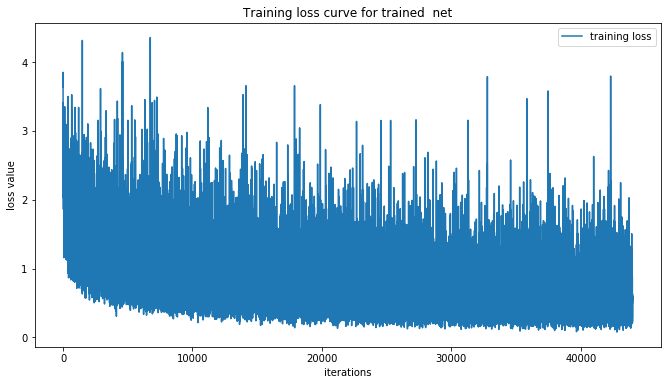

In [19]:
%%time
%matplotlib inline
torch.cuda.empty_cache()
# Deep copy in order to train the network with the same initialized weights
trained_net = copy.deepcopy(untrained_net)
trained_net = trained_net.to(device)

# set loss function for the net
trained_net.criterion = nn.CrossEntropyLoss(ignore_index=-1)
# You can change the number of EPOCHS
EPOCH = 200

# switch to train mode (original untrained_net was set to eval mode)
trained_net.train()

optimizer = get_optimizer(trained_net)

print("Starting Training...")

loss_graph = []

fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

for e in range(EPOCH):
    loss = train(train_loader, trained_net, optimizer, loss_graph, device)
    ax.clear()
    ax.set_xlabel('iterations')
    ax.set_ylabel('loss value')
    ax.set_title('Training loss curve for trained  net')
    ax.plot(loss_graph, label='training loss')
    ax.legend(loc='upper right')
    fig.canvas.draw()
    print("Epoch: {} Loss: {}".format(e, loss))
    del loss

In [20]:
def validate(val_loader, net):
    iou_arr = []
    val_loss = 0
    
    net.eval()
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            img, gt_seg_img = data.to(device), target.to(device)
            
            output = net(img)
            
            if device != 'cpu':
                output = output.cpu()
                gt_seg_img = gt_seg_img.cpu()
            pred = torch.argmax(output, dim=1).numpy()[0]
            
            gt_np = gt_seg_img.numpy()[0]
            
            conf = eval_semantic_segmentation(pred[None], gt_np[None])
            
            iou_arr.append(conf['miou'])
            
    return val_loss, (sum(iou_arr) / len(iou_arr))

In [21]:
val_data = DataLoaderSegmentation('val')
val_loader = DataLoader(val_data, batch_size=1, shuffle=True, num_workers=0)

In [22]:
%%time
print("mIoU over the training dataset:{}".format(validate(train_loader, trained_net)[1]))

C:\Users\Jack Capombassis\miniconda3\envs\carnd-term1\lib\site-packages\chainercv\evaluations\eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
C:\Users\Jack Capombassis\miniconda3\envs\carnd-term1\lib\site-packages\chainercv\evaluations\eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


mIoU over the training dataset:0.4145669716489606
Wall time: 1min 6s


In [23]:
%%time
print("mIoU over the validation dataset:{}".format(validate(val_loader, trained_net)[1]))

mIoU over the validation dataset:0.409587992866767
Wall time: 17.7 s


View count of pixels within each label category:
(array([ 5,  6,  8,  9, 10, 14, 16, 22], dtype=int64), array([  1153,  13387,  49656,   5374,     53,  22098,   7414, 163009],
      dtype=int64))
(array([ 0,  1,  5,  6,  7,  8,  9, 11, 14, 16, 22], dtype=int64), array([14680, 88465,  5388, 34156,  2349, 36400,    42,  4006, 10191,
       10539, 55928], dtype=int64))
View count of pixels within each label category:
(array([ 1,  5,  6,  7, 10], dtype=int64), array([ 15203, 141988,  50244,  53424,   1285], dtype=int64))
(array([ 1,  4,  5,  6,  7, 22], dtype=int64), array([ 11503,     18, 142395,  72082,  36097,     49], dtype=int64))
View count of pixels within each label category:
(array([ 0,  7, 11, 16, 17, 20, 22], dtype=int64), array([61208, 34335, 73699, 31635, 58411,  1252,  1604], dtype=int64))
(array([ 0,  1,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 22],
      dtype=int64), array([74031,  1693,  5803, 16073, 54218,  1388,  3850,  1922, 12267,
        8231,   199,  

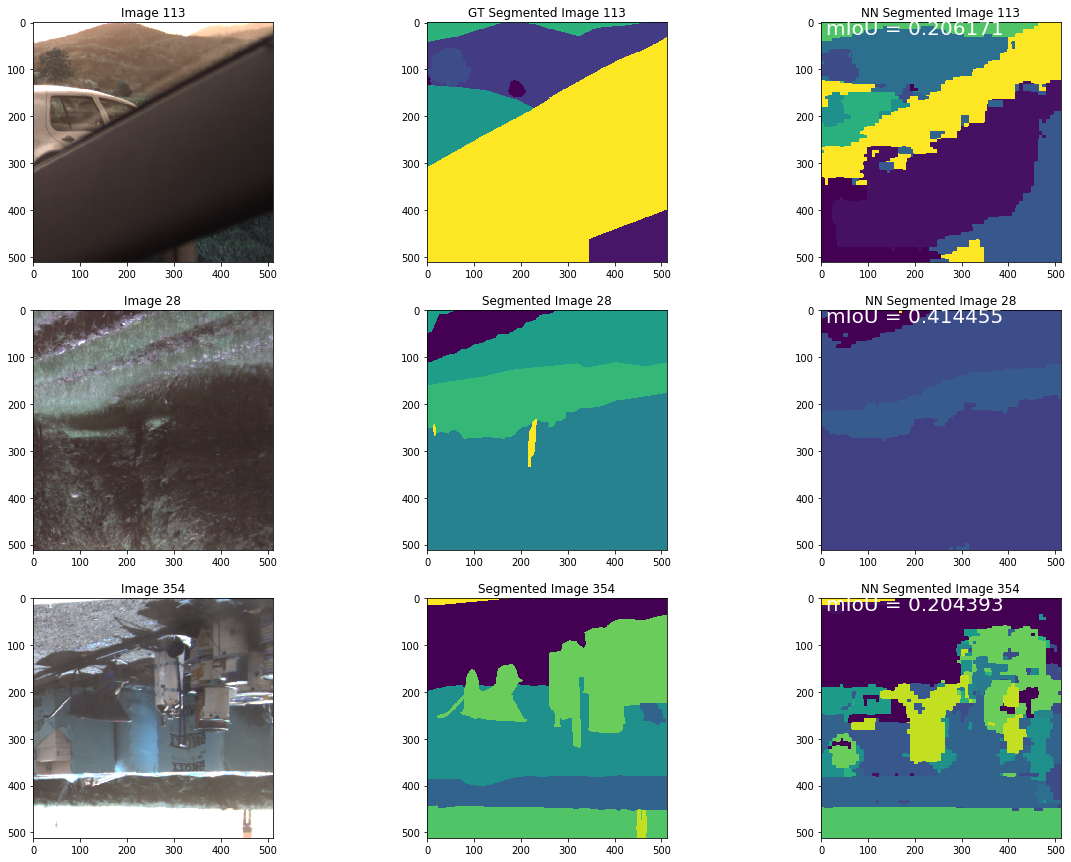

In [28]:
trained_net.eval()

def add_img_txt_plot(fig, index, img, title, sub_plot_id, txt):
    ax = fig.add_subplot(sub_plot_id[0],sub_plot_id[1],sub_plot_id[2])
    plt.title(title + str(index))
    ax.text(10, 25, 'mIoU = {:_>8.6f}'.format(txt), fontsize=20, color='white')
    ax.imshow(img)
    
def get_nn_seg_img(net, img, mask):
    img, get_seg_img = img, mask
    
    nn_seg_output = net.forward(img[None].cuda())
    
    if device != 'cpu':
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).cpu().numpy()[0]
    else:
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).numpy()[0]
        
    gts = get_seg_img.cpu().numpy()
    
    conf = eval_semantic_segmentation(nn_seg_img[None], gts[None])
    
    print("View count of pixels within each label category:")
    print(np.unique(get_seg_img, return_counts=True))
    print(np.unique(nn_seg_img, return_counts=True))
    
    return nn_seg_img, conf['miou']


img_113, seg_img_113 = val_data[20]
img_28, seg_img_28 = train_data[9]
img_354, seg_img_354 = train_data[100]

nn_seg_img_113, miou_113 = get_nn_seg_img(trained_net, img_113, seg_img_113)
nn_seg_img_28, miou_28 = get_nn_seg_img(trained_net, img_28, seg_img_28)
nn_seg_img_354, miou_354 = get_nn_seg_img(trained_net, img_354, seg_img_354)


fig = plt.figure(figsize=(20,15))

add_img_plot(fig, 113, np.rollaxis(img_113.numpy().astype(int), 0, 3), 'Image ', [3,3,1])
add_img_plot(fig, 113, colorize_mask(seg_img_113), 'GT Segmented Image ', [3,3,2])
add_img_txt_plot(fig, 113, colorize_mask_nn_output(nn_seg_img_113), 'NN Segmented Image ', [3,3,3], miou_113)
add_img_plot(fig, 28, np.rollaxis(img_28.numpy().astype(int), 0, 3), 'Image ', [3,3,4])
add_img_plot(fig, 28, colorize_mask(seg_img_28), 'Segmented Image ', [3,3,5])
add_img_txt_plot(fig, 28, colorize_mask_nn_output(nn_seg_img_28), 'NN Segmented Image ', [3,3,6], miou_28)
add_img_plot(fig, 354, np.rollaxis(img_354.numpy().astype(int), 0, 3), 'Image ', [3,3,7])
add_img_plot(fig, 354, colorize_mask(seg_img_354), 'Segmented Image ', [3,3,8])
add_img_txt_plot(fig, 354, colorize_mask_nn_output(nn_seg_img_354), 'NN Segmented Image ', [3,3,9], miou_354)


In [25]:
test_data = DataLoaderSegmentation('test')

View count of pixels within each label category:
(array([ 1,  5,  6,  7,  8, 16], dtype=int64), array([  9217,   9238,  39144, 180745,  15428,   8372], dtype=int64))


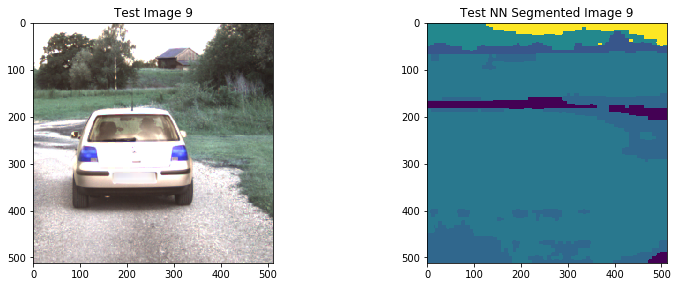

In [26]:
def get_nn_seg_img_test(net, data):
    img = data

    nn_seg_output = net.forward(img[None].cuda())

    if device != 'cpu':
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).cpu().numpy()[0]
    else:
        nn_seg_img = torch.argmax(nn_seg_output, dim=1).numpy()[0]

    print("View count of pixels within each label category:")
    print(np.unique(nn_seg_img, return_counts=True))

    return nn_seg_img

test_img_9 = test_data[9]

test_nn_seg_img_9 = get_nn_seg_img_test(trained_net, test_data[9])

fig = plt.figure(figsize=(20,15))

add_img_plot(fig, 9, np.rollaxis(test_img_9.numpy().astype(int), 0, 3),'Test Image ', [3,3,1])
add_img_plot(fig, 9, colorize_mask_nn_output(test_nn_seg_img_9), 'Test NN Segmented Image ', [3,3,2])

In [38]:
import torch.backends.cudnn as cudnn

checkpoint = None
batch_size = 8
iterations = 2200
weight_decay = 5e-4
momentum = 0.9

cudnn.benchmark = True

def save_checkpoint(epoch, model, optimizer, scheduler):
    """
    Save model checkpoint.

    :param epoch: epoch number
    :param model: model
    :param optimizer: optimizer
    :param base_type: The base network type
    """
    state = {'epoch': epoch,
             'model': model,
             'optimizer': optimizer,
             'scheduler': scheduler}
    if scheduler == None:
        filename = 'checkpoint_mobilenet_v2.pth.tar'
    else:
        filename = 'checkpoint_mobilenet_v2_scheduler.pth.tar'
    torch.save(state, filename)

def train_mobilenet_v2(lr_type):
    """
    Training.
    """
    global start_epoch, label_map, epoch, checkpoint, delay_lr_at
    
    train_dataset = DataLoaderSegmentation('train')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    if lr_type == 'original_scheduler':
        lr = 1e-1
        decay_lr_at = [1300, 1800] # decay learning rate after this many iterations
        decay_lr_to = 0.1
    elif lr_type == 'pytorch_scheduler':
        lr = 1e-3
    else:
        raise NotImplementedError
        
    epochs = iterations // (len(train_dataset) // batch_size)
    
    if lr_type == 'original_scheduler':
        decay_lr_at = [it // (len(train_dataset) // batch_size) for it in decay_lr_at]
        print("Epochs to decay learning rate:", decay_lr_at)
    
    if checkpoint is None:
        start_epoch = 0
        model = copy.deepcopy(untrained_net)
        
        optimizer = torch.optim.SGD(model.parameters(),
                               lr=lr,
                               weight_decay=weight_decay,
                               momentum=momentum,
                               nesterov=False)
        if lr_type == 'pytorch_scheduler':
            raise NotImplementedError
    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']
        if lr_type == 'pytorch_scheduler':
            raise NotImplementedError
        
    model = model.to(device)
    model.criterion = nn.CrossEntropyLoss(ignore_index=-1)
    
    loss_graph = []
    
    fig = plt.figure(figsize=(12,6))
    plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
    ax = fig.add_subplot(1,1,1)
    
    for epoch in range(start_epoch, epochs):
        
        if lr_type == 'original_scheduler':
            if epoch in decay_lr_at:
                adjust_learning_rate(optimizer, decay_lr_to)

        loss = train_model(train_loader=train_loader, model=model,loss_graph=loss_graph, epoch=epoch, device=device, optimizer=optimizer)
        if lr_type == 'pytorch_scheduler':
            raise NotImplementedError
        
        if lr_type == 'original_scheduler':
            save_checkpoint(epoch, model, optimizer, scheduler=None)
        else:
            save_checkpoint(epoch, model, optimizer, scheduler)
            
        ax.clear()
        ax.set_xlabel('iterations')
        ax.set_ylabel('loss value')
        ax.set_title('Training loss curve for trained  net')
        ax.plot(loss_graph, label='training loss')
        ax.legend(loc='upper right')
        fig.canvas.draw()
        print("Epoch: {} Loss: {}".format(epoch, loss))

def train_model(train_loader, model, optimizer, epoch, device, loss_graph):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        img, gt_seg_img = data.to(device), target.to(device)
        
        main_loss = model(img, gts=gt_seg_img)
        
        loss_graph.append(main_loss.item())
        
        print(main_loss.item())
        
        optimizer.zero_grad()
        main_loss.backward()
        optimizer.step()

    return main_loss

Epochs to decay learning rate: [23, 32]


RuntimeError: CUDA out of memory. Tried to allocate 4.03 GiB (GPU 0; 8.00 GiB total capacity; 3.90 GiB already allocated; 2.00 GiB free; 4.14 GiB reserved in total by PyTorch)

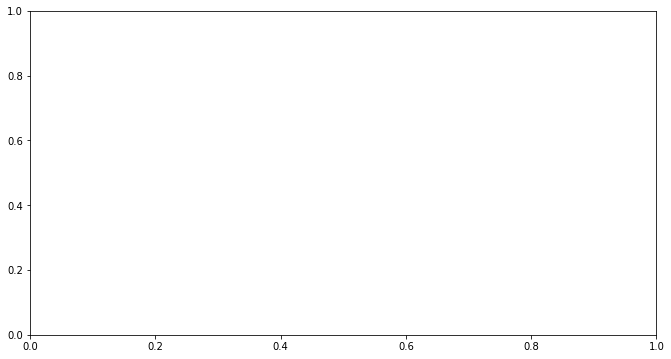

In [39]:
train_mobilenet_v2('original_scheduler')